In [1]:
# Import packages.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import glob
import os
from numpy.random import seed
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from scipy import stats
import random
from sklearn.metrics import mean_squared_error
import timeit
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
from xgboost.sklearn import XGBRegressor
import xgboost as xgb
import sklearn.metrics
import matplotlib.pylab as pylab

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Plotting defaults
params = {'legend.fontsize': 15,
         'axes.labelsize': 15,
         'axes.titlesize':20,
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'legend.title_fontsize': 15
         }
pylab.rcParams.update(params)


In [2]:
# Prior data wrangling notebook ends with a csv save of train_master dataset. Load dataset here.
train_csv = "train_master.csv"
dates = ['TIME_SCHEDULED',
         'ARRIVAL',
         'DEPARTURE',
         'Date',
         'SURVEY_DATE_EFFECTIVE',
         'BRONCOS_TIME']
trains = pd.read_csv(train_csv,
                    header=0,
                     sep=',',
                     index_col=0,
                     infer_datetime_format=True,
                     parse_dates=dates)
trains.sort_values(by=['TIME_SCHEDULED'],inplace=True)
trains.info(verbose=True, null_counts=True)

C:\Users\jsummer\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (49,50,51,52,53,54,55,56,57,75) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\jsummer\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1838225 entries, 0 to 1838221
Data columns (total 103 columns):
 #   Column                                Non-Null Count    Dtype         
---  ------                                --------------    -----         
 0   SERIAL_NUMBER                         1838225 non-null  int64         
 1   SCHEDULE_NAME                         1838225 non-null  object        
 2   SIGNUP_NAME                           1838225 non-null  object        
 3   SURVEY_SOURCE                         1838225 non-null  int64         
 4   PATTERN_ID                            1838225 non-null  int64         
 5   BRANCH                                1838225 non-null  object        
 6   ROUTE_NUMBER                          1838225 non-null  int64         
 7   ROUTE_NAME                            1838225 non-null  object        
 8   DIRECTION_NAME                        1838225 non-null  object        
 9   SERVICE_TYPE                          1838225

In [3]:
# Remove records corresponding to the final stop of a route
trains = trains.loc[trains.END_OF_LINE == 0]

Add prior delays to the dataset, indicating the departure delay at prior 1st, 2nd, 3rd, and 4th station.

In [6]:
def prior_delay(df,shift_value):
    """
       Returns dataframe and correlation of previous (n) station's delay and current delay.
    
       Parameters:
       df: train station data that must include SERIAL_NUMBER, TIME_SCHEDULED, DEPARTURE_DELAY, and END_OF_LINE
       shift_value: represents n stations in past
    
    """  
    # Sort values by serial number and time scheduled and reset index
    df = df.sort_values(by=['SERIAL_NUMBER','TIME_SCHEDULED'])
    df.reset_index(inplace=True)
    
    # Create a smaller dataframe with delay and matching fields
    df_shifted = df[['SERIAL_NUMBER','DEPARTURE_DELAY']].shift(shift_value)
    
    # Create a new field to capture the prior n delay
    new_field = 'prior_departure_delay'+'_'+str(shift_value)
    df_shifted.columns=['SERIAL_NUMBER',new_field]
      
    # Merge the reduced dataframe into the master matching indeces and ensuring serial numbers match
    df = pd.merge(df,
                 df_shifted,
                 #on='SERIAL_NUMBER',
                 left_index=True,
                 right_index=True,
                 how='left')
    
    # Replace NaN fields with 0 as previous delays at non-existent trains would effectively be 0
    df[new_field].fillna(0, inplace=True)
    
    # Iterate over rows to identify prior delays pulled from mismatched serial number
    for index, row in df.iterrows():
        prior_index = index - shift_value
        if prior_index >=0:
            if row['SERIAL_NUMBER_x'] != df.at[prior_index, 'SERIAL_NUMBER_x']:
                df.at[index,new_field] = 0
    
    # Drop the extraneous SERIAL_NUMBER FIELD and set original SERIAL_NUMBER to original format
    df = df.drop(['SERIAL_NUMBER_y'], axis=1)
    df = df.rename(columns={'SERIAL_NUMBER_x':'SERIAL_NUMBER'})
    df =  df[df.columns.drop(list(df.filter(regex='index')))]
    df =  df[df.columns.drop(list(df.filter(regex='level')))]
    
    
    return df

In [7]:
trains = prior_delay(trains,1)
trains = prior_delay(trains,2)
trains = prior_delay(trains,3)
trains = prior_delay(trains,4)

In [4]:
# Remove columns that are not necessary for modeling
train_X = trains.drop(['SERIAL_NUMBER','SCHEDULE_NAME','SIGNUP_NAME','SURVEY_SOURCE','PATTERN_ID','SERVICE_MODE','SURVEY_DATE_EFFECTIVE',
                          'SURVEY_DATE_ATYPICAL','TRIP_KEY','BLOCK_NUMBER','VEHICLE_NUMBER','GARAGE_NAME','DIVISION_NAME','SORT_ORDER',
                          'STOP_ID','MAIN_CROSS_STREET','TIMEPOINT','COUNTY','TRIP_DIFF_MINUTES','EVENT_COUNT','APC_COUNT',
                          'EARLY','ON_TIME','LATE','RECORD_ID','STOPABBR','SCHEDULED_DAY','ARRIVAL_TIME','DEPART_TIME','WAIT_TIME_CALC',
                          'Broncos_Date','Broncos_Time','DELAYED_FLG','END_OF_LINE','no_weather_type','Weather Type','Smoke Or Haze','Sea Level Pressure',  
                          'Minimum Temperature','Maximum Temperature','Date','Dew Point','Cloud Cover','Fog','Precipitation Cover', 'Rox_Time_2','Ice',
                          'LATITUDE','LONGITUDE','SERVICE_TYPE','ROUTE_NAME','SERVICE_PERIOD','Heat Index', 'Wind Gust', 'Wind Chill'
], axis=1)

In [5]:
# Create minutes until start of game for broncos, avalanche, rockies, and nuggets games
train_X['NUGGETS_TIME'] = pd.to_datetime(train_X['Nuggets_Date'] + ' ' + train_X['Nuggets_Time'])
train_X['AVALANCHE_TIME'] = pd.to_datetime(train_X['Avs_Date'] + ' ' + train_X['Avs_Time'])
train_X['ROCKIES_TIME'] = pd.to_datetime(train_X['Rox_Date'] + ' ' + train_X['Rox_Time_1'])

train_X = train_X.drop(['Nuggets_Date','Nuggets_Time','Avs_Date','Avs_Time','Rox_Date','Rox_Time_1'], axis=1)

sports = ['BRONCOS','AVALANCHE','NUGGETS','ROCKIES']
for team in sports:
    field = 'HOURS_TIL_'+team
    train_X[field] = (train_X[team+'_TIME'] - train_X['TIME_SCHEDULED'])
    train_X[field] = train_X[field]/np.timedelta64(1,'h')
    train_X[field].fillna(100000, inplace=True)

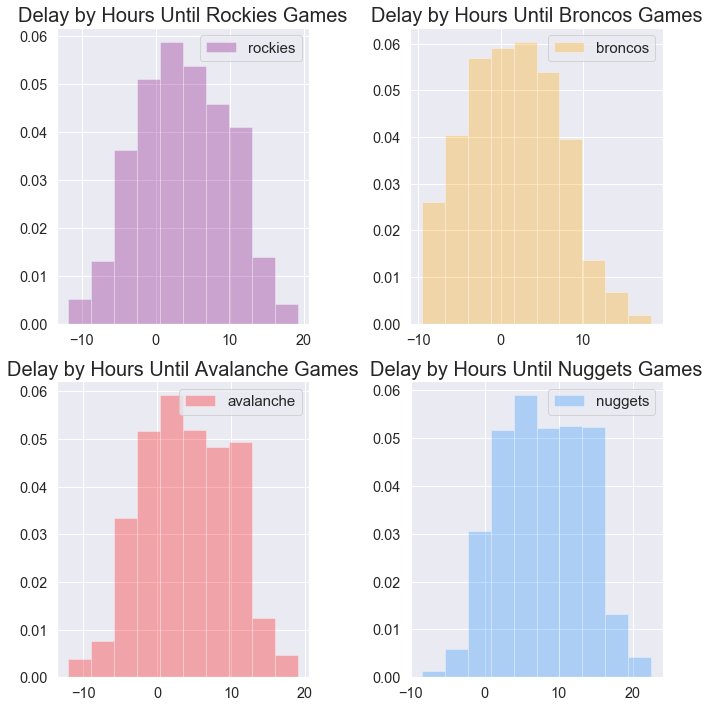

In [6]:
# Ensure hours until sporting events doesn't introduce any anamolies and are somewhat evenly distributed or bell shaped as expected
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.hist(train_X['HOURS_TIL_ROCKIES'].loc[train_X['HOURS_TIL_ROCKIES']!=100000], color='purple', alpha = 0.3, label='rockies', density=True)
plt.title('Delay by Hours Until Rockies Games')
plt.legend()
plt.subplot(2,2,2)
plt.hist(train_X['HOURS_TIL_BRONCOS'].loc[train_X['HOURS_TIL_BRONCOS']!=100000], color='orange', alpha=0.3,label='broncos', density=True)
plt.title('Delay by Hours Until Broncos Games')
plt.legend()
plt.subplot(2,2,3)
plt.hist(train_X['HOURS_TIL_AVALANCHE'].loc[train_X['HOURS_TIL_AVALANCHE']!=100000], color='red', alpha = 0.3, label='avalanche', density=True)
plt.title('Delay by Hours Until Avalanche Games')
plt.legend()
plt.subplot(2,2,4)
plt.hist(train_X['HOURS_TIL_NUGGETS'].loc[train_X['HOURS_TIL_NUGGETS']!=100000], color='dodgerblue', alpha = 0.3, label='nuggets', density=True)
plt.title('Delay by Hours Until Nuggets Games')
plt.legend()
plt.tight_layout()
plt.show()

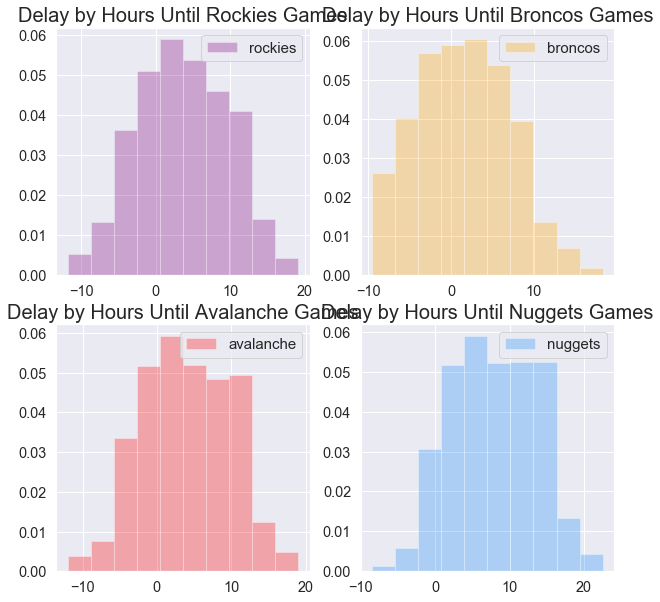

In [12]:
# Ensure hours until sporting events doesn't introduce any anamolies and are somewhat evenly distributed or bell shaped as expected
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.hist(train_X['HOURS_TIL_ROCKIES'].loc[train_X['HOURS_TIL_ROCKIES']!=100000], color='purple', alpha = 0.3, label='rockies', density=True)
plt.title('Delay by Hours Until Rockies Games')
plt.legend()
plt.subplot(2,2,2)
plt.hist(train_X['HOURS_TIL_BRONCOS'].loc[train_X['HOURS_TIL_BRONCOS']!=100000], color='orange', alpha=0.3,label='broncos', density=True)
plt.title('Delay by Hours Until Broncos Games')
plt.legend()
plt.subplot(2,2,3)
plt.hist(train_X['HOURS_TIL_AVALANCHE'].loc[train_X['HOURS_TIL_AVALANCHE']!=100000], color='red', alpha = 0.3, label='avalanche', density=True)
plt.title('Delay by Hours Until Avalanche Games')
plt.legend()
plt.subplot(2,2,4)
plt.hist(train_X['HOURS_TIL_NUGGETS'].loc[train_X['HOURS_TIL_NUGGETS']!=100000], color='dodgerblue', alpha = 0.3, label='nuggets', density=True)
plt.title('Delay by Hours Until Nuggets Games')
plt.legend()
plt.show()

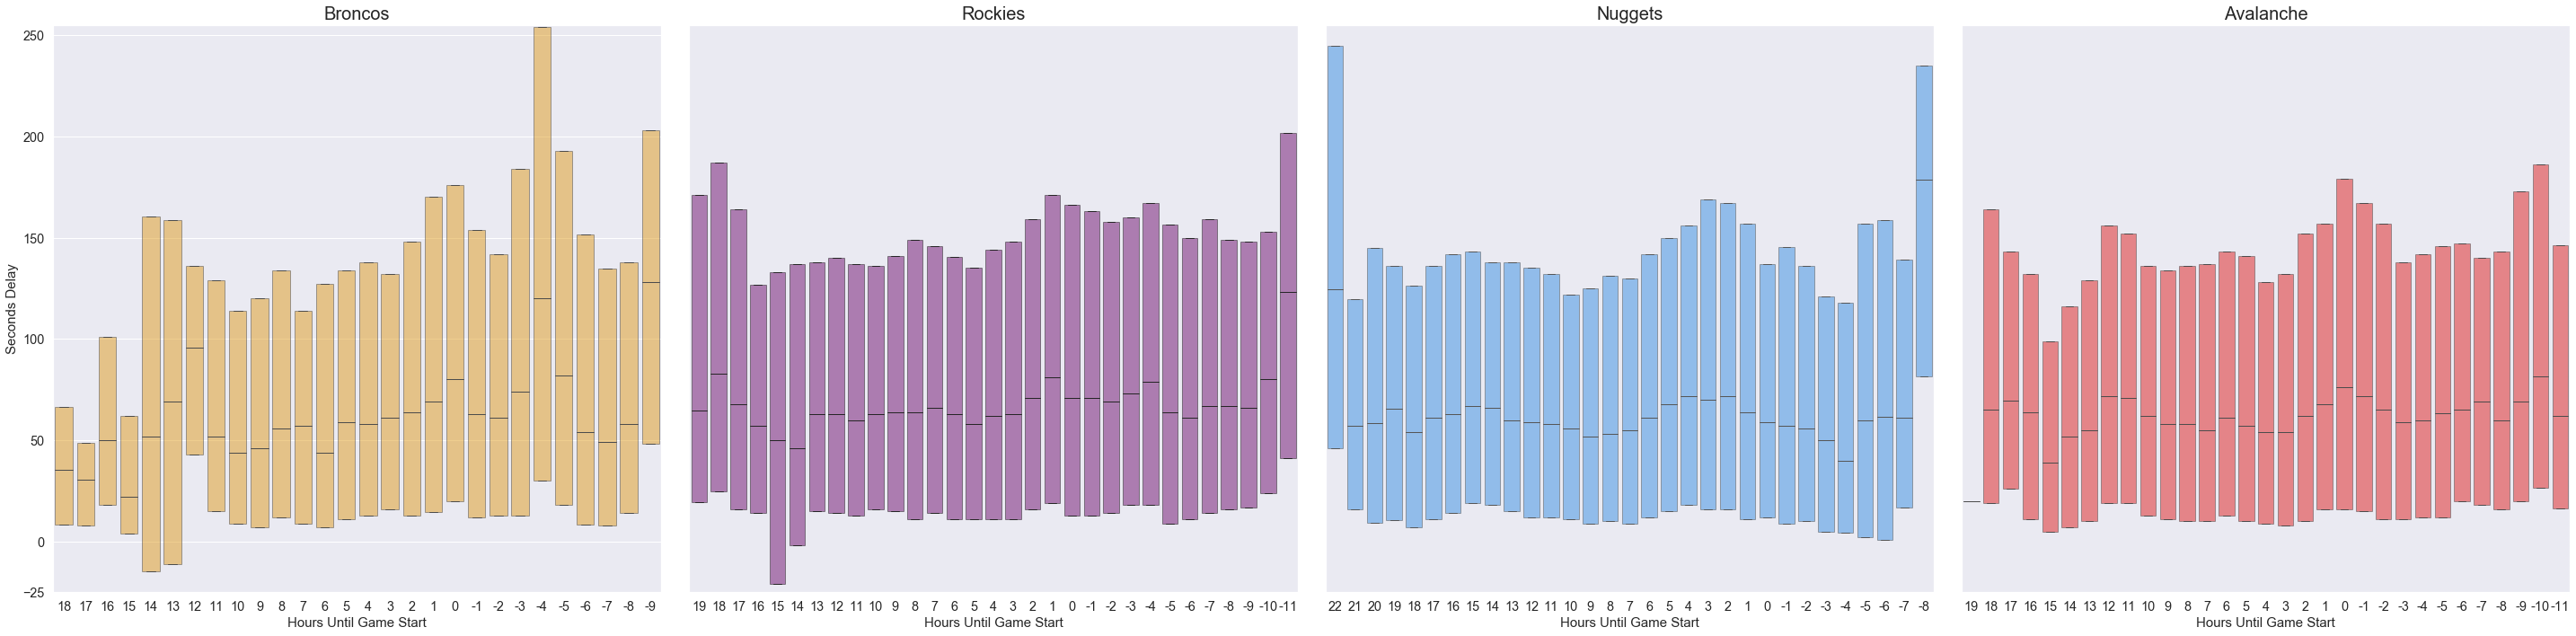

In [13]:
plt.subplots(figsize=(40,10))
col_palette=['orange','purple','dodgerblue','red']
labels=['Broncos','Rockies','Nuggets','Avalanche']
for idx,team in enumerate(['HOURS_TIL_BRONCOS','HOURS_TIL_ROCKIES','HOURS_TIL_NUGGETS','HOURS_TIL_AVALANCHE']):
    plt.subplot(1,4,idx+1)
    ax=sns.boxplot(x=train_X[team].astype('int').loc[train_X[team]!=100000],
                y='DEPARTURE_DELAY',
                data=train_X,
                showfliers=False,
               linewidth=1,
                color=col_palette[idx],
                whis=False)
    plt.title(labels[idx])
    plt.ylabel(' ')
    plt.xlabel('Hours Until Game Start')
    plt.gca().invert_xaxis()
    plt.setp(ax.artists, alpha=.5)
    plt.ylim(-25,255)
    plt.yticks([])
    if idx==0:
        plt.yticks([-25,0, 50, 100, 150,200,250])
        plt.ylabel('Seconds Delay')
    plt.tight_layout()    
plt.show()


Create ordinal weather columns for rain, snow, and ice weather descriptions

| Rain Description                    | Rank        |   
| -----------                         | ----------- |
| Light Drizzle                       | 1           |
| Drizzle                             | 2           |
| Heavy Drizzle                       | 3           |
| Mist                                | 4           |
| Light Rain                          | 5           |
| Rain                                | 6           |
| Heavy Rain                          | 7           |
| Rain Showers                        | 8           |
| Thunderstorm                        | 9           |

| Snow Description                    | Rank        |
| -----------                         | ----------- |
| Light Snow                          | 1           |
| Light Rain and Snow                 | 2           |
| Snow                                | 3           |
| Blowing or Drifting Snow            | 4           |
| Heavy Snow                          | 5           |


| Ice Description                     | Rank        |
| -----------                         | ----------- |
| Light Freezing Drizzle/Freezing Rain| 1           |
| Light Freezing Rain                 | 2           |
| Freezing Drizzle/Freezing Rain      | 3           |
| Hail Showers                        | 4           |


In [14]:
def ordinal_weather (train_X,weather_dict,weather_name):
    
    """
    Creates a singular ordinal weather column for a weather type, such as rain, snow, and ice. 
    
    Parameters:
    train_X: Dataframe including a variety of binary weather indicator columns
    weather_dict: A dictionary of weather types and ordinal value describing a single overarching weather pattern, such as rain, snow, or ice
    weather_name: String indicating weather category to be used to create the ordinal weather field 

    """
    sorted(weather_dict.items(), key=lambda x: x[1])
    weather_field = weather_name+'_ord'
    train_X[weather_field] = 0
    for key, value in weather_dict.items():
        train_X.loc[train_X[key] == 1,weather_field] = value
    
    return train_X

In [15]:
# Create ordinal fields for rain, snow, and hail weather patterns.
rain_dict = {'Light Drizzle':1,
        'Drizzle':2,
        'Heavy Drizzle':3,
        'Mist':4,
        'Light Rain':5,
        'Rain':6,
        'Heavy Rain':7,
        'Rain Showers':8,
        'Thunderstorm':9
       }

snow_dict = {'Light Snow':1,
        'Light Rain And Snow':2,
        'Snow':3,
        'Blowing Or Drifting Snow':4,
        'Heavy Snow':5
       }

hail_dict = {'Light Freezing Drizzle/Freezing Rain':1,
        'Light Freezing Rain':2,
        'Freezing Drizzle/Freezing Rain':3,
        'Hail Showers':4
       }

# Run function to create weather fields
ordinal_weather(train_X,rain_dict, 'rain')
ordinal_weather(train_X,snow_dict, 'snow')
ordinal_weather(train_X,hail_dict, 'hail')

# Remove now unnecessary weather fields from dictionaries made above
weather_list = []
for dict_items in [rain_dict, snow_dict, hail_dict]:
    for key in dict_items.keys():
        weather_list.append(key)
train_X = train_X.drop(weather_list, axis=1)

In [16]:
# Drop additional fields
train_X = train_X.drop(['ARRIVAL','DEPARTURE','TIME_TO_SCH_DEPART','BRONCOS_TIME','DWELL_TIME','NUGGETS_TIME','AVALANCHE_TIME','ROCKIES_TIME'], axis=1)

# Create dummies indicator fields for string columns.
train_X = pd.get_dummies(train_X,columns=['STOPNAME','BRANCH','DIRECTION_NAME','TIME_PERIOD','SERVICE_DAY','CITY','LOOKUP_COUNTY','ROUTE_NUMBER'])

In [17]:
# Function to fill NaN fields
def NA_col_filler (df,column_list,input_value):
    """
    Enters the input value into the NaN values of columns specified.
    
    Parameters:
    -df: dataframe containing columns to update
    -column_list: selected list of columns containing NaN values to update
    -input_value: the value used as the NaN replacement
    
    """
    
    for col in column_list:
        df[col].fillna(input_value, inplace=True)
    return df

In [18]:
# Fill hours til sporting events fields with 100,000
hour_cols = ['HOURS_TIL_BRONCOS','HOURS_TIL_ROCKIES','HOURS_TIL_AVALANCHE','HOURS_TIL_NUGGETS']
NA_col_filler(train_X,hour_cols,100000)

# Set NaN values in FREE_RUNNING to 0.
free_running = ['FREE_RUNNING']
NA_col_filler(train_X,free_running,0)

,TIME_SCHEDULED,FREE_RUNNING,DEPARTURE_DELAY,Wind Direction,Precipitation,Relative Humidity,Temperature,Visibility,Wind Speed,Snow Depth,...,LOOKUP_COUNTY_Adams,LOOKUP_COUNTY_Arapahoe,LOOKUP_COUNTY_Denver,LOOKUP_COUNTY_Jefferson,ROUTE_NUMBER_101,ROUTE_NUMBER_103,ROUTE_NUMBER_107,ROUTE_NUMBER_109,ROUTE_NUMBER_111,ROUTE_NUMBER_113
0,2018-12-01 00:57:00,0.0,11.0,204.0,NaN,72.60,31.3,5.5,4.1,NaN,...,0,0,1,0,0,0,0,0,1,0
1,2018-12-01 01:06:00,0.0,75.0,210.0,NaN,72.14,29.7,5.5,5.3,NaN,...,0,0,1,0,0,0,0,0,1,0
2,2018-12-01 01:10:00,0.0,46.0,211.0,NaN,61.86,32.0,4.9,5.6,NaN,...,1,0,0,0,0,0,0,0,1,0
3,2018-12-01 01:16:00,0.0,46.0,211.0,NaN,61.86,32.0,4.9,5.6,NaN,...,1,0,0,0,0,0,0,0,1,0
4,2018-12-01 01:19:00,0.0,90.0,210.0,NaN,72.14,29.7,5.5,5.3,NaN,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1756314,2019-11-24 10:12:00,-1.0,16.0,225.0,NaN,18.69,53.5,10.0,14.3,NaN,...,0,0,1,0,0,1,0,0,0,0
1756315,2019-11-24 10:14:00,-1.0,15.0,225.0,NaN,18.69,53.5,10.0,14.3,NaN,...,0,0,1,0,0,1,0,0,0,0
1756316,2019-11-24 10:17:00,-1.0,27.0,225.0,NaN,18.69,53.5,10.0,14.3,NaN,...,0,0,1,0,0,1,0,0,0,0
1756317,2019-11-24 10:18:15,-1.0,22.0,225.0,NaN,18.69,53.5,10.0,14.3,NaN,...,0,0,1,0,0,1,0,0,0,0


C:\Users\jsummer\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\jsummer\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


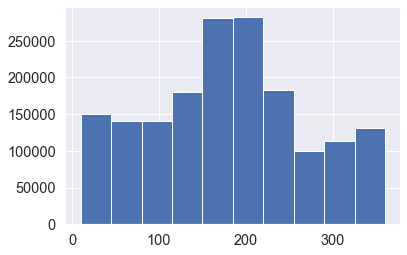

,TIME_SCHEDULED,FREE_RUNNING,DEPARTURE_DELAY,Wind Direction,Precipitation,Relative Humidity,Temperature,Visibility,Wind Speed,Snow Depth,...,LOOKUP_COUNTY_Adams,LOOKUP_COUNTY_Arapahoe,LOOKUP_COUNTY_Denver,LOOKUP_COUNTY_Jefferson,ROUTE_NUMBER_101,ROUTE_NUMBER_103,ROUTE_NUMBER_107,ROUTE_NUMBER_109,ROUTE_NUMBER_111,ROUTE_NUMBER_113
0,2018-12-01 00:57:00,0.0,11.0,204.0,NaN,72.60,31.3,5.5,4.1,NaN,...,0,0,1,0,0,0,0,0,1,0
1,2018-12-01 01:06:00,0.0,75.0,210.0,NaN,72.14,29.7,5.5,5.3,NaN,...,0,0,1,0,0,0,0,0,1,0
2,2018-12-01 01:10:00,0.0,46.0,211.0,NaN,61.86,32.0,4.9,5.6,NaN,...,1,0,0,0,0,0,0,0,1,0
3,2018-12-01 01:16:00,0.0,46.0,211.0,NaN,61.86,32.0,4.9,5.6,NaN,...,1,0,0,0,0,0,0,0,1,0
4,2018-12-01 01:19:00,0.0,90.0,210.0,NaN,72.14,29.7,5.5,5.3,NaN,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1756314,2019-11-24 10:12:00,-1.0,16.0,225.0,NaN,18.69,53.5,10.0,14.3,NaN,...,0,0,1,0,0,1,0,0,0,0
1756315,2019-11-24 10:14:00,-1.0,15.0,225.0,NaN,18.69,53.5,10.0,14.3,NaN,...,0,0,1,0,0,1,0,0,0,0
1756316,2019-11-24 10:17:00,-1.0,27.0,225.0,NaN,18.69,53.5,10.0,14.3,NaN,...,0,0,1,0,0,1,0,0,0,0
1756317,2019-11-24 10:18:15,-1.0,22.0,225.0,NaN,18.69,53.5,10.0,14.3,NaN,...,0,0,1,0,0,1,0,0,0,0


In [19]:
plt.hist(train_X['Wind Direction'])
plt.show()

# Set NaN values in Wind Direction to avergae value.
wind_direction = ['Wind Direction']
avg_wind_direction = train_X['Wind Direction'].mean()
NA_col_filler(train_X,wind_direction,avg_wind_direction)

C:\Users\jsummer\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\jsummer\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


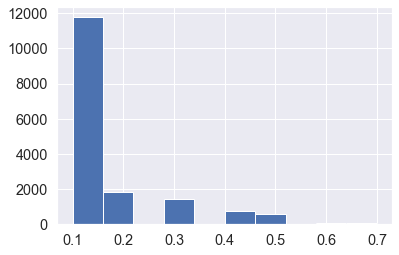

,TIME_SCHEDULED,FREE_RUNNING,DEPARTURE_DELAY,Wind Direction,Precipitation,Relative Humidity,Temperature,Visibility,Wind Speed,Snow Depth,...,LOOKUP_COUNTY_Adams,LOOKUP_COUNTY_Arapahoe,LOOKUP_COUNTY_Denver,LOOKUP_COUNTY_Jefferson,ROUTE_NUMBER_101,ROUTE_NUMBER_103,ROUTE_NUMBER_107,ROUTE_NUMBER_109,ROUTE_NUMBER_111,ROUTE_NUMBER_113
0,2018-12-01 00:57:00,0.0,11.0,204.0,0.0,72.60,31.3,5.5,4.1,NaN,...,0,0,1,0,0,0,0,0,1,0
1,2018-12-01 01:06:00,0.0,75.0,210.0,0.0,72.14,29.7,5.5,5.3,NaN,...,0,0,1,0,0,0,0,0,1,0
2,2018-12-01 01:10:00,0.0,46.0,211.0,0.0,61.86,32.0,4.9,5.6,NaN,...,1,0,0,0,0,0,0,0,1,0
3,2018-12-01 01:16:00,0.0,46.0,211.0,0.0,61.86,32.0,4.9,5.6,NaN,...,1,0,0,0,0,0,0,0,1,0
4,2018-12-01 01:19:00,0.0,90.0,210.0,0.0,72.14,29.7,5.5,5.3,NaN,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1756314,2019-11-24 10:12:00,-1.0,16.0,225.0,0.0,18.69,53.5,10.0,14.3,NaN,...,0,0,1,0,0,1,0,0,0,0
1756315,2019-11-24 10:14:00,-1.0,15.0,225.0,0.0,18.69,53.5,10.0,14.3,NaN,...,0,0,1,0,0,1,0,0,0,0
1756316,2019-11-24 10:17:00,-1.0,27.0,225.0,0.0,18.69,53.5,10.0,14.3,NaN,...,0,0,1,0,0,1,0,0,0,0
1756317,2019-11-24 10:18:15,-1.0,22.0,225.0,0.0,18.69,53.5,10.0,14.3,NaN,...,0,0,1,0,0,1,0,0,0,0


In [20]:
plt.hist(train_X['Precipitation'])
plt.show()

# Set NaN values in Precipitation to 0.
precipitation = ['Precipitation']
NA_col_filler(train_X,precipitation,0)

C:\Users\jsummer\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\jsummer\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


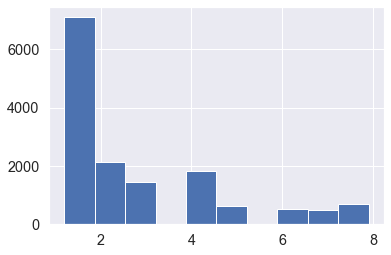

,TIME_SCHEDULED,FREE_RUNNING,DEPARTURE_DELAY,Wind Direction,Precipitation,Relative Humidity,Temperature,Visibility,Wind Speed,Snow Depth,...,LOOKUP_COUNTY_Adams,LOOKUP_COUNTY_Arapahoe,LOOKUP_COUNTY_Denver,LOOKUP_COUNTY_Jefferson,ROUTE_NUMBER_101,ROUTE_NUMBER_103,ROUTE_NUMBER_107,ROUTE_NUMBER_109,ROUTE_NUMBER_111,ROUTE_NUMBER_113
0,2018-12-01 00:57:00,0.0,11.0,204.0,0.0,72.60,31.3,5.5,4.1,0.0,...,0,0,1,0,0,0,0,0,1,0
1,2018-12-01 01:06:00,0.0,75.0,210.0,0.0,72.14,29.7,5.5,5.3,0.0,...,0,0,1,0,0,0,0,0,1,0
2,2018-12-01 01:10:00,0.0,46.0,211.0,0.0,61.86,32.0,4.9,5.6,0.0,...,1,0,0,0,0,0,0,0,1,0
3,2018-12-01 01:16:00,0.0,46.0,211.0,0.0,61.86,32.0,4.9,5.6,0.0,...,1,0,0,0,0,0,0,0,1,0
4,2018-12-01 01:19:00,0.0,90.0,210.0,0.0,72.14,29.7,5.5,5.3,0.0,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1756314,2019-11-24 10:12:00,-1.0,16.0,225.0,0.0,18.69,53.5,10.0,14.3,0.0,...,0,0,1,0,0,1,0,0,0,0
1756315,2019-11-24 10:14:00,-1.0,15.0,225.0,0.0,18.69,53.5,10.0,14.3,0.0,...,0,0,1,0,0,1,0,0,0,0
1756316,2019-11-24 10:17:00,-1.0,27.0,225.0,0.0,18.69,53.5,10.0,14.3,0.0,...,0,0,1,0,0,1,0,0,0,0
1756317,2019-11-24 10:18:15,-1.0,22.0,225.0,0.0,18.69,53.5,10.0,14.3,0.0,...,0,0,1,0,0,1,0,0,0,0


In [21]:
plt.hist(train_X['Snow Depth'])
plt.show()

snow_depth = ['Snow Depth']
NA_col_filler(train_X,snow_depth,0)

In [22]:
def nearfill_cols (df, field, timedelta):
    """
    Fills out the selected field based on nearest possible values
    
    Parameters:
    -df: dataframe containing the fields to fill in the event of NaN values
    -field: field entered as a string corresponding to the field to receive the NaN replacement values
    -timedelta: the pandas timedelta unit to operate as a threshold for replacing the nearest NaN
    
    """
    df.sort_values(by=['TIME_SCHEDULED'], inplace=True)
    df.reset_index(inplace=True)
    df =  df[df.columns.drop(list(df.filter(regex='index')))]
    df =  df[df.columns.drop(list(df.filter(regex='level')))]
    merger_df = df[['TIME_SCHEDULED',field]].loc[df[field].notnull()]
    df = pd.merge_asof(df, merger_df, on='TIME_SCHEDULED', direction='nearest', tolerance=pd.Timedelta(timedelta))
    df.drop(df.loc[:, df.columns.str.endswith('_x')], axis=1, inplace=True)
    df.rename(columns={df.columns[-1]: field.upper()}, inplace = True)
    return df

In [23]:
# Fill NA for Relative Humidity, Temperature, and Wind Speed from close records with non null values.
train_X = nearfill_cols(train_X, 'Relative Humidity','5h')
train_X = nearfill_cols(train_X, 'Temperature','3h')
train_X = nearfill_cols(train_X, 'Wind Speed','4h')
train_X = nearfill_cols(train_X, 'Visibility','3h')

In [24]:
# Make all column names lowercase
train_X.columns = [x.lower() for x in train_X.columns]

# Replace spaces in column names with underscores
train_X.columns = train_X.columns.str.replace(' ', '_')


In [25]:
# Create monthly dummy indicator fields
train_X['month'] = train_X['time_scheduled'].dt.month
train_X = pd.get_dummies(train_X,columns = ['month'])

# Create duplicate dataframe for further exploration of input data later
train_X_duplicate = train_X

# Drop time_scheduled field
train_X = train_X.drop(['time_scheduled'], axis=1)

Visualizing correlation across features to identify if specific features are correlated and redundancies can be removed. (https://ajh1143.github.io/Corr/)

In [26]:
train_X.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1756319 entries, 0 to 1756318
Data columns (total 175 columns):
 #   Column                                                         Dtype  
---  ------                                                         -----  
 0   free_running                                                   float64
 1   departure_delay                                                float64
 2   wind_direction                                                 float64
 3   precipitation                                                  float64
 4   snow_depth                                                     float64
 5   lightning_without_thunder                                      int64  
 6   prior_departure_delay_1                                        float64
 7   prior_departure_delay_2                                        float64
 8   prior_departure_delay_3                                        float64
 9   prior_departure_delay_4                      

In [27]:
def halfHeatMap(df, mirror):

       # Create Correlation df
       corr = df.corr()
       # Plot figsize
       fig, ax = plt.subplots(figsize=(60, 30))
       # Generate Color Map
       colormap = sns.diverging_palette(220, 10, as_cmap=True)

       if mirror == True:
          #Generate Heat Map, allow annotations and place floats in map
          sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
          #Apply xticks
          plt.xticks(range(len(corr.columns)), corr.columns);
          #Apply yticks
          plt.yticks(range(len(corr.columns)), corr.columns)
          #show plot

       else:
          # Drop self-correlations
          dropSelf = np.zeros_like(corr)
          dropSelf[np.triu_indices_from(dropSelf)] = True
          # Generate Color Map
          colormap = sns.diverging_palette(220, 10, as_cmap=True)
          # Generate Heat Map, allow annotations and place floats in map
          sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f", mask=dropSelf)
          # Apply xticks
          plt.xticks(range(len(corr.columns)), corr.columns);
          # Apply yticks
          plt.yticks(range(len(corr.columns)), corr.columns)
       # show plot
       plt.title('Correlation Matrix')
       plt.show()

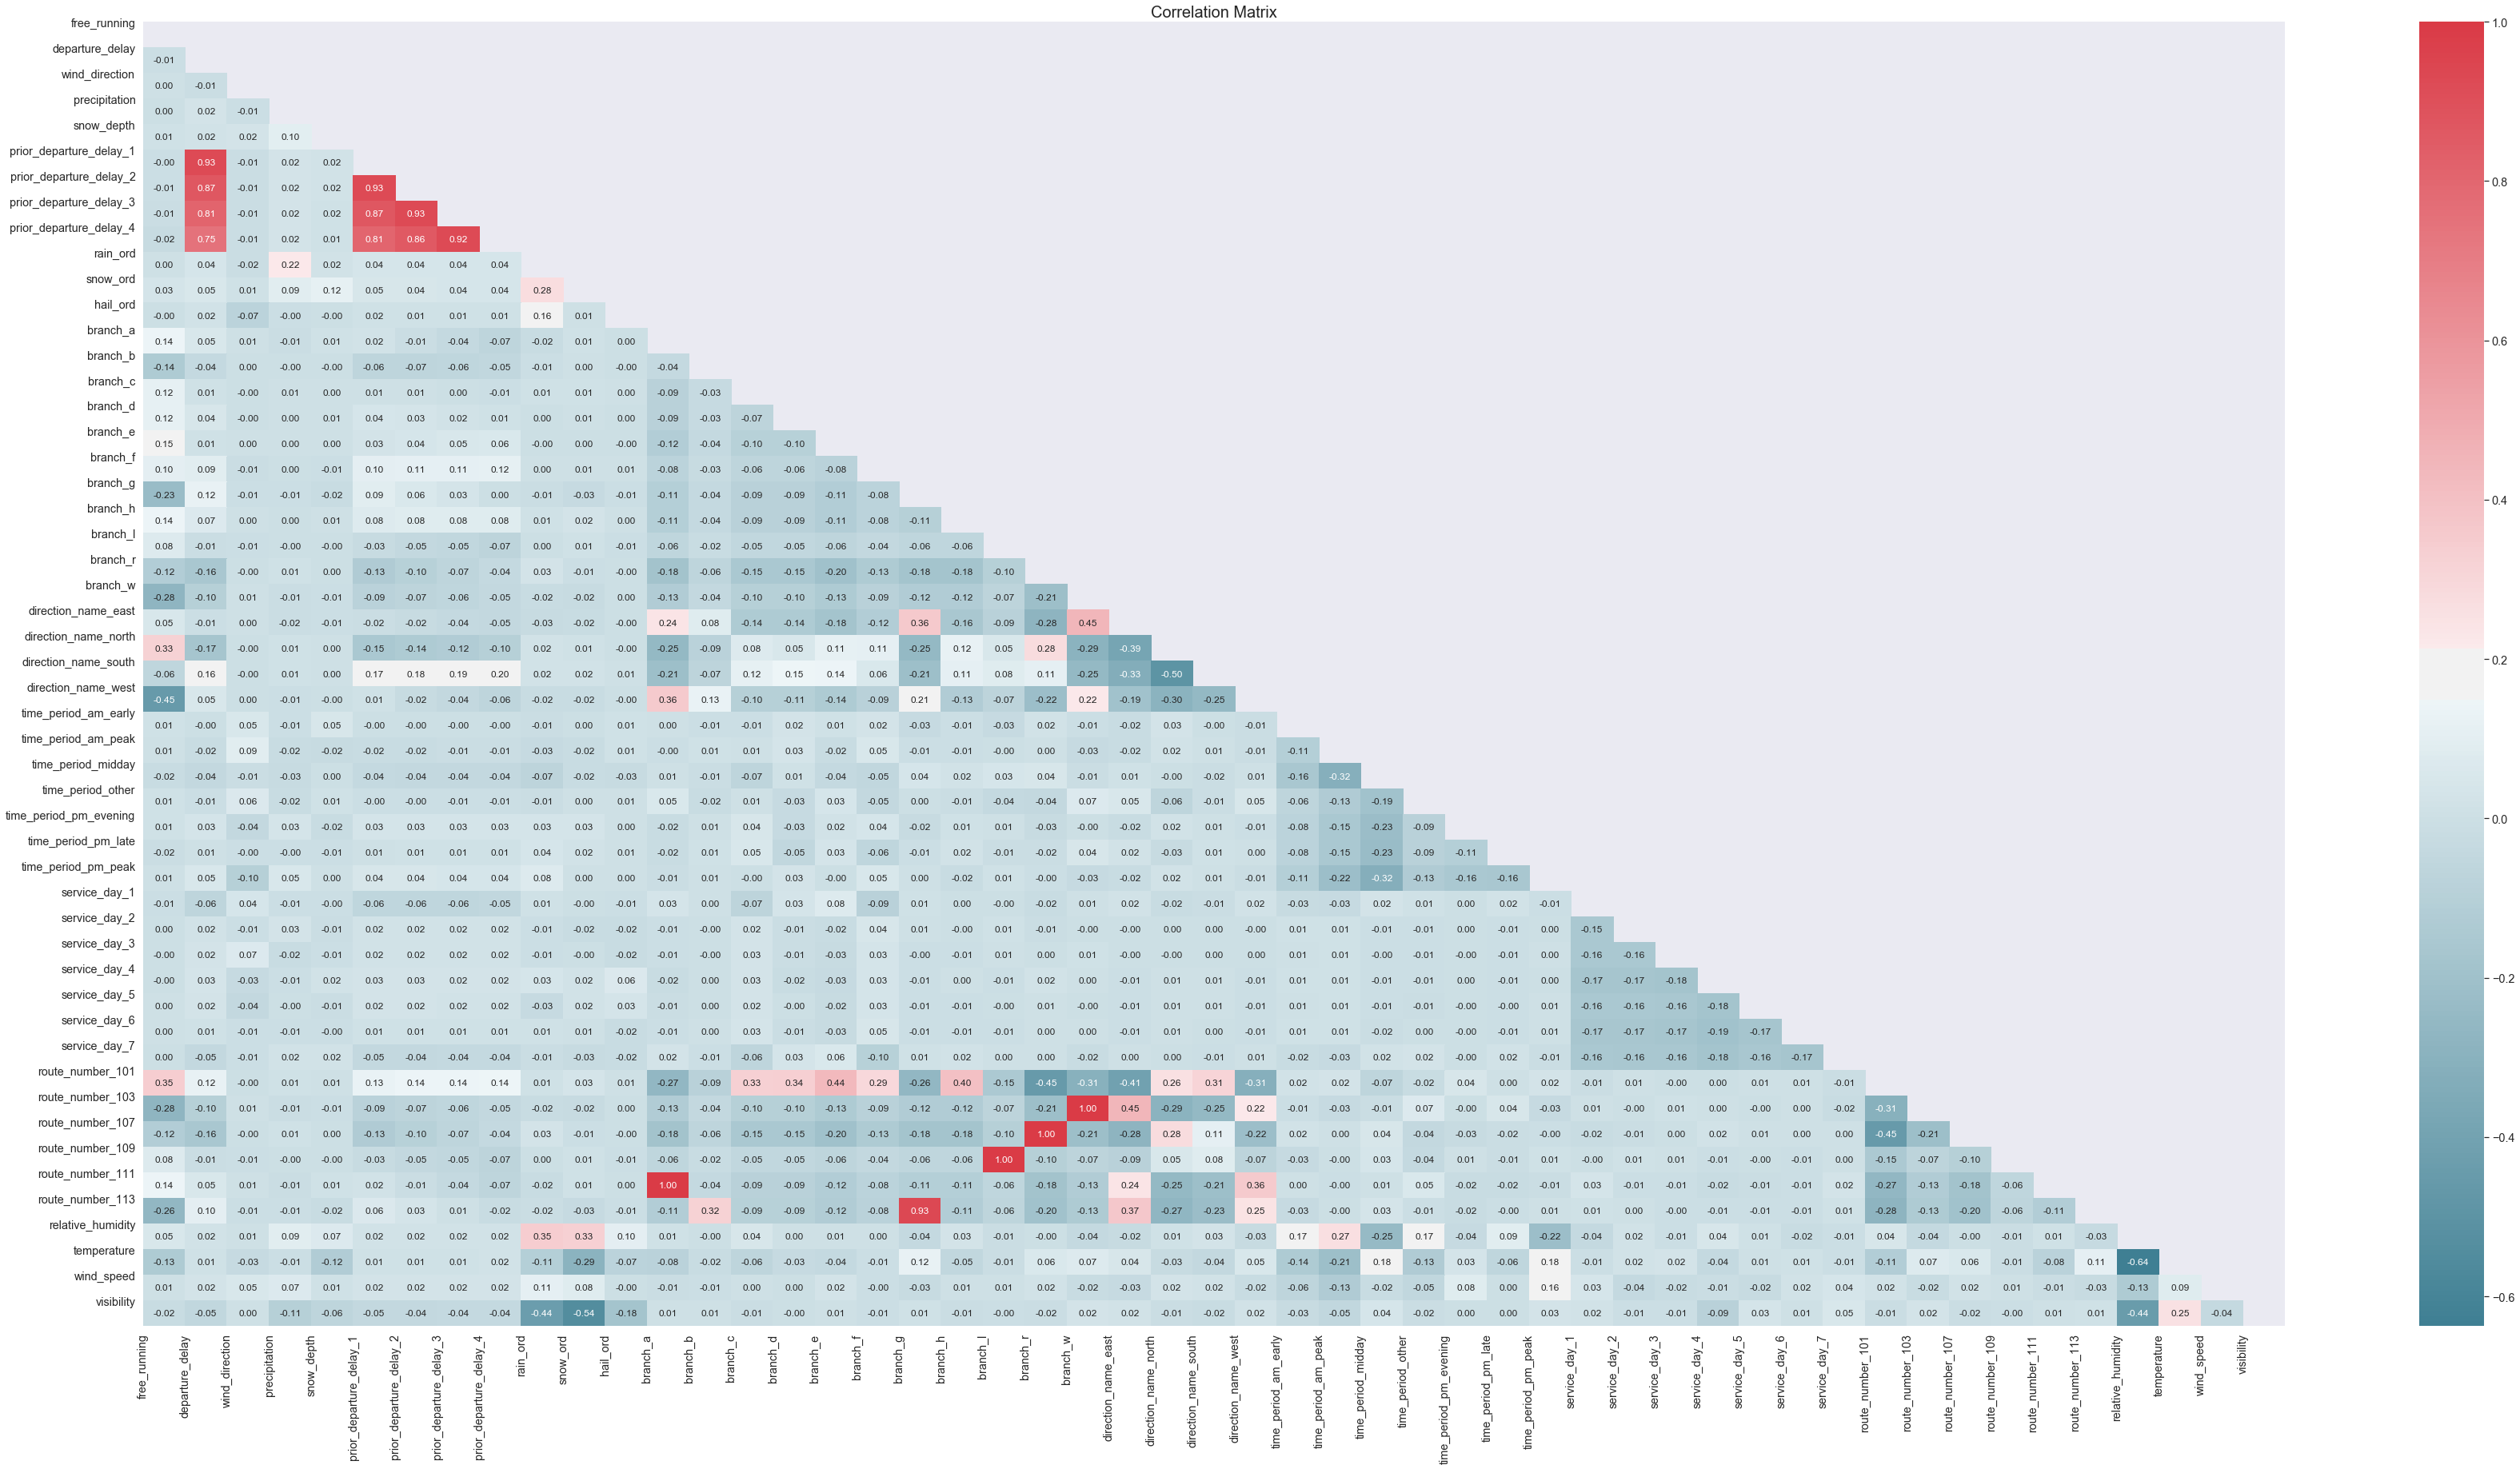

In [28]:
df_corr_1 = train_X[['free_running',
                   'departure_delay',
                   'wind_direction',
                   'precipitation',
                   'snow_depth',
                   'prior_departure_delay_1',
                   'prior_departure_delay_2',
                   'prior_departure_delay_3',
                   'prior_departure_delay_4',
                   'rain_ord',
                   'snow_ord',
                   'hail_ord',
                   'branch_a',
                   'branch_b',
                   'branch_c',
                   'branch_d',
                   'branch_e',
                   'branch_f',
                   'branch_g',
                   'branch_h',
                   'branch_l',
                   'branch_r',
                   'branch_w',
                   'direction_name_east',
                   'direction_name_north',
                   'direction_name_south',
                   'direction_name_west',
                   'time_period_am_early',
                   'time_period_am_peak',
                   'time_period_midday',
                   'time_period_other',
                   'time_period_pm_evening',
                   'time_period_pm_late',
                   'time_period_pm_peak',
                   'service_day_1',
                   'service_day_2',
                   'service_day_3',
                   'service_day_4',
                   'service_day_5',
                   'service_day_6',
                   'service_day_7',
                   'route_number_101',
                   'route_number_103',
                   'route_number_107',
                   'route_number_109',
                   'route_number_111',
                   'route_number_113',
                   'relative_humidity',
                   'temperature',
                   'wind_speed',
                   'visibility'
]]
halfHeatMap(df_corr_1, mirror=False)

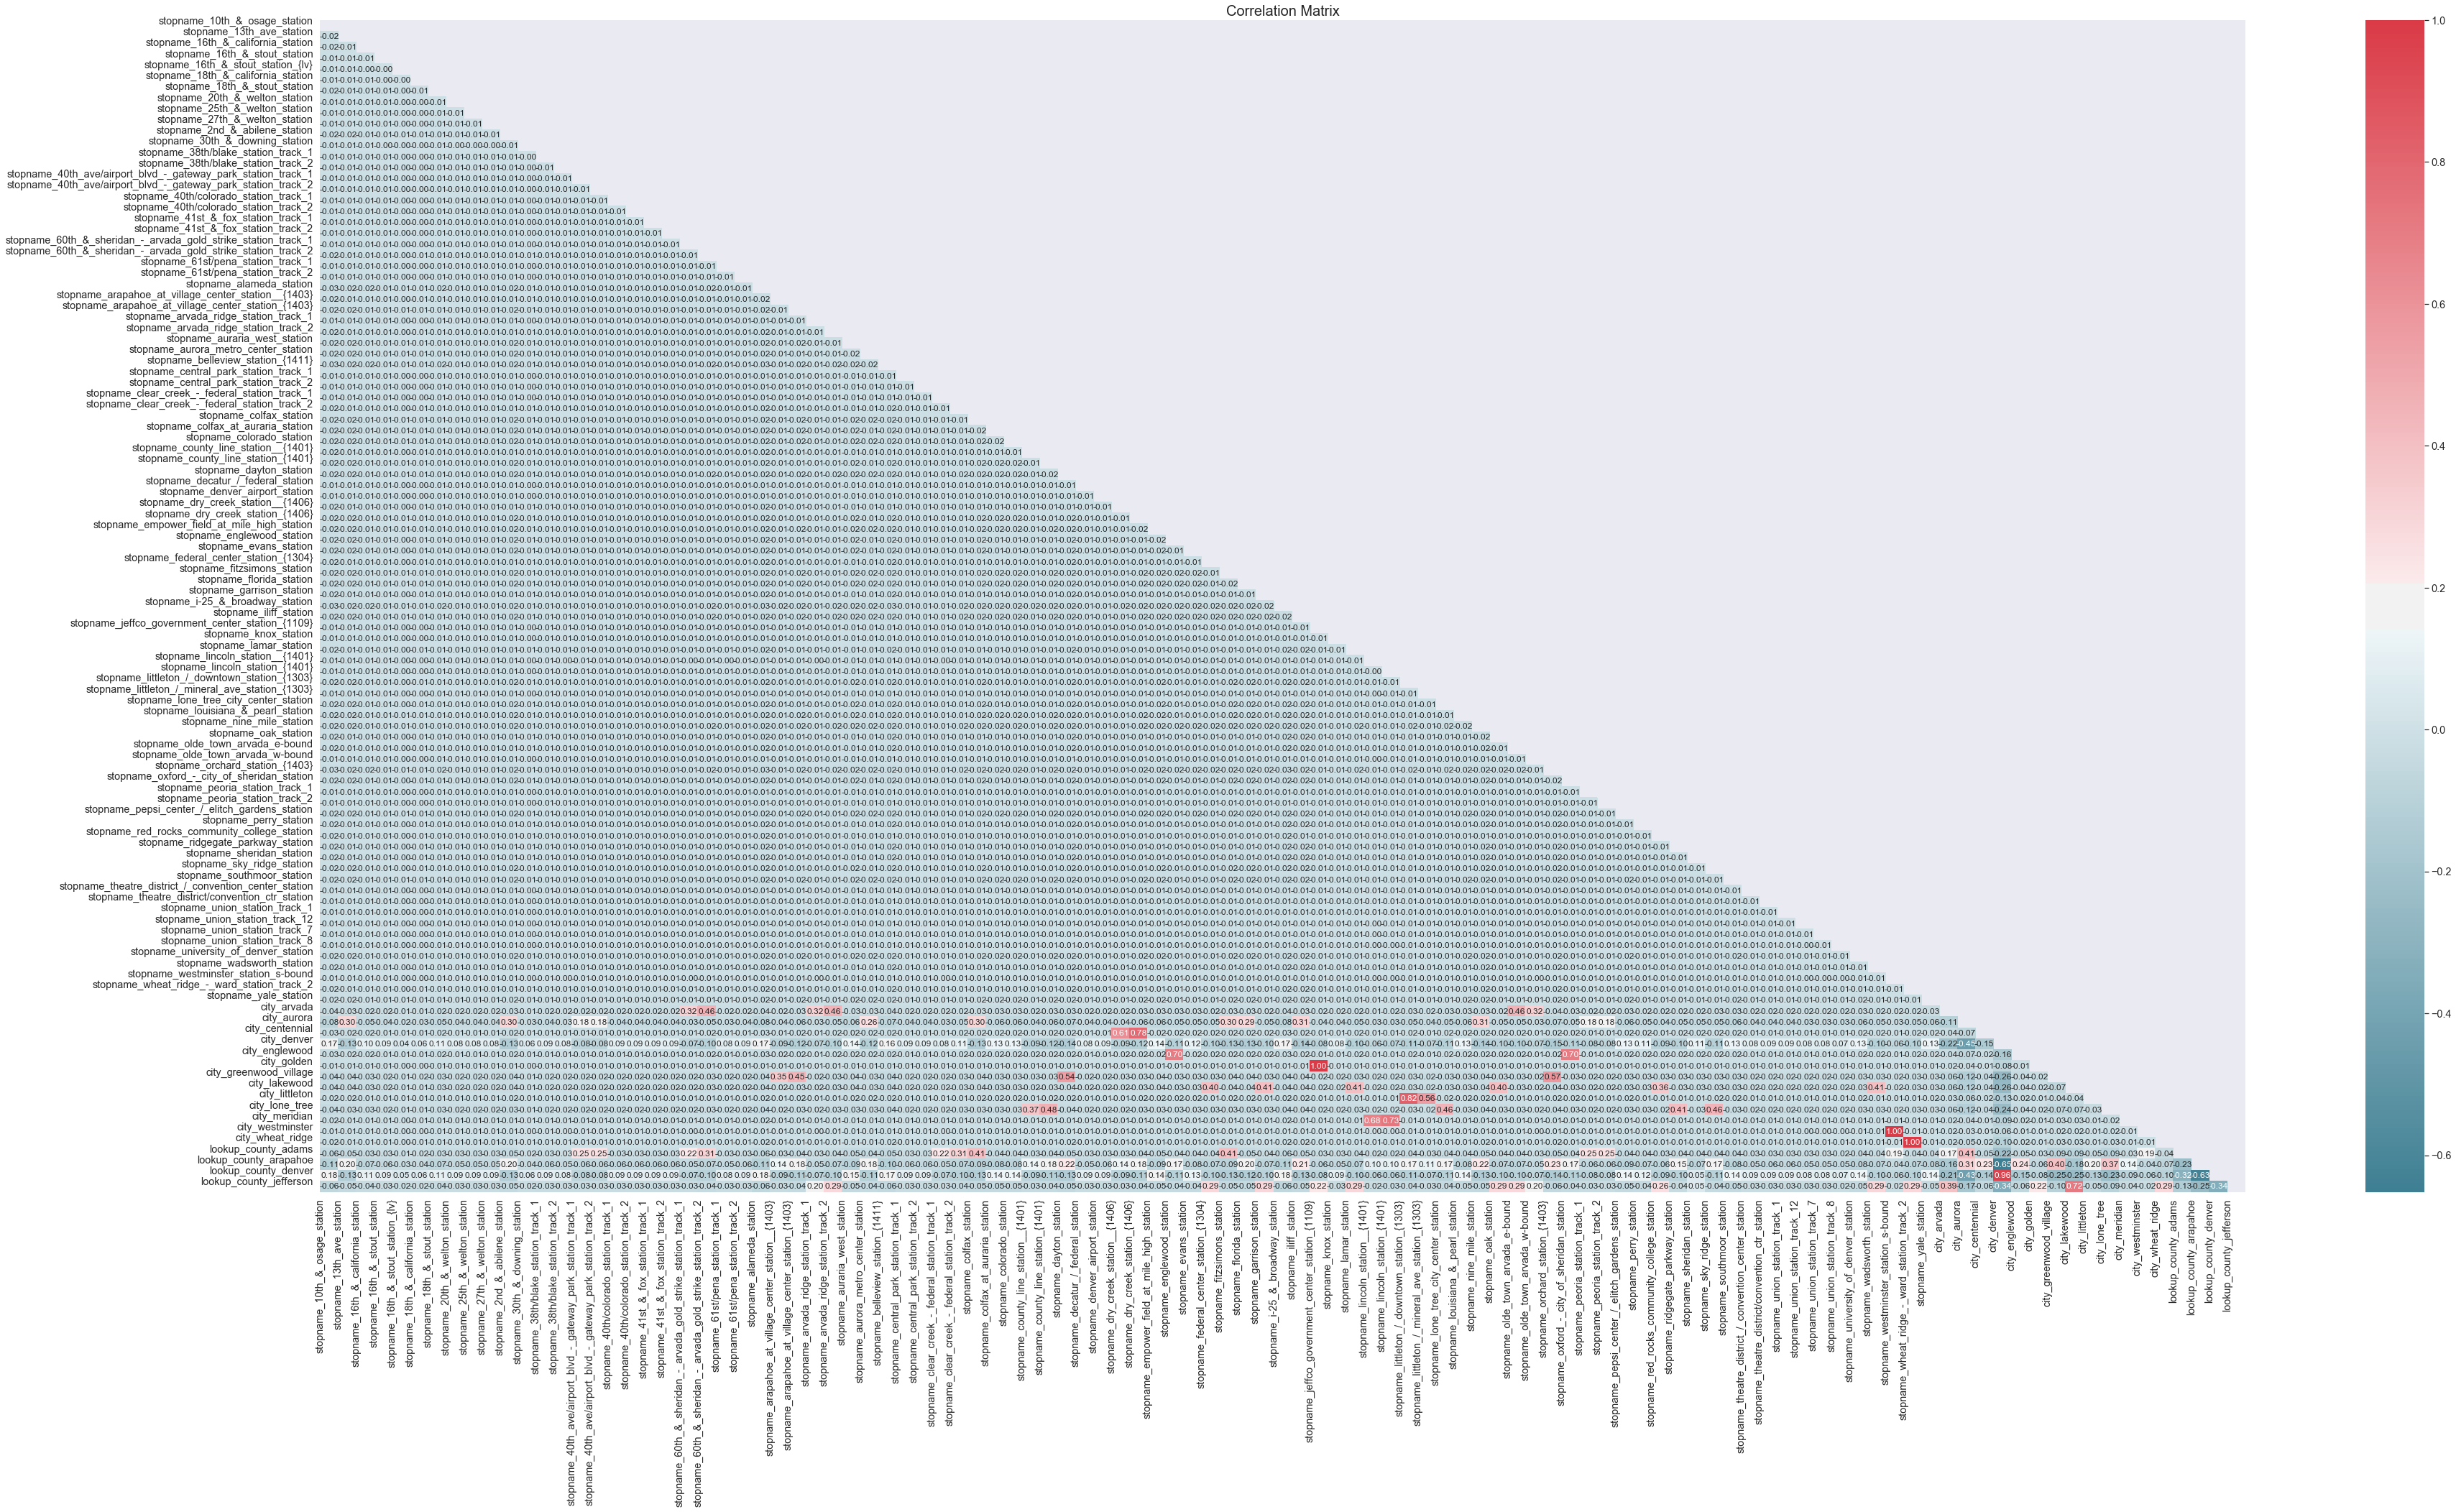

In [29]:
df_corr_2 = train_X[[
'stopname_10th_&_osage_station',
'stopname_13th_ave_station',
'stopname_16th_&_california_station',
'stopname_16th_&_stout_station',
'stopname_16th_&_stout_station_{lv}',
'stopname_18th_&_california_station',
'stopname_18th_&_stout_station',
'stopname_20th_&_welton_station',
'stopname_25th_&_welton_station',
'stopname_27th_&_welton_station',
'stopname_2nd_&_abilene_station',
'stopname_30th_&_downing_station',
'stopname_38th/blake_station_track_1',
'stopname_38th/blake_station_track_2',
'stopname_40th_ave/airport_blvd_-_gateway_park_station_track_1',
'stopname_40th_ave/airport_blvd_-_gateway_park_station_track_2',
'stopname_40th/colorado_station_track_1',
'stopname_40th/colorado_station_track_2',
'stopname_41st_&_fox_station_track_1',
'stopname_41st_&_fox_station_track_2',
'stopname_60th_&_sheridan_-_arvada_gold_strike_station_track_1',
'stopname_60th_&_sheridan_-_arvada_gold_strike_station_track_2',
'stopname_61st/pena_station_track_1',
'stopname_61st/pena_station_track_2',
'stopname_alameda_station',
'stopname_arapahoe_at_village_center_station__{1403}',
'stopname_arapahoe_at_village_center_station_{1403}',
'stopname_arvada_ridge_station_track_1',
'stopname_arvada_ridge_station_track_2',
'stopname_auraria_west_station',
'stopname_aurora_metro_center_station',
'stopname_belleview_station_{1411}',
'stopname_central_park_station_track_1',
'stopname_central_park_station_track_2',
'stopname_clear_creek_-_federal_station_track_1',
'stopname_clear_creek_-_federal_station_track_2',
'stopname_colfax_station',
'stopname_colfax_at_auraria_station',
'stopname_colorado_station',
'stopname_county_line_station__{1401}',
'stopname_county_line_station_{1401}',
'stopname_dayton_station',
'stopname_decatur_/_federal_station',
'stopname_denver_airport_station',
'stopname_dry_creek_station__{1406}',
'stopname_dry_creek_station_{1406}',
'stopname_empower_field_at_mile_high_station',
'stopname_englewood_station',
'stopname_evans_station',
'stopname_federal_center_station_{1304}',
'stopname_fitzsimons_station',
'stopname_florida_station',
'stopname_garrison_station',
'stopname_i-25_&_broadway_station',
'stopname_iliff_station',
'stopname_jeffco_government_center_station_{1109}',
'stopname_knox_station',
'stopname_lamar_station',
'stopname_lincoln_station__{1401}',
'stopname_lincoln_station_{1401}',
'stopname_littleton_/_downtown_station_{1303}',
'stopname_littleton_/_mineral_ave_station_{1303}',
'stopname_lone_tree_city_center_station',
'stopname_louisiana_&_pearl_station',
'stopname_nine_mile_station',
'stopname_oak_station',
'stopname_olde_town_arvada_e-bound',
'stopname_olde_town_arvada_w-bound',
'stopname_orchard_station_{1403}',
'stopname_oxford_-_city_of_sheridan_station',
'stopname_peoria_station_track_1',
'stopname_peoria_station_track_2',
'stopname_pepsi_center_/_elitch_gardens_station',
'stopname_perry_station',
'stopname_red_rocks_community_college_station',
'stopname_ridgegate_parkway_station',
'stopname_sheridan_station',
'stopname_sky_ridge_station',
'stopname_southmoor_station',
'stopname_theatre_district_/_convention_center_station',
'stopname_theatre_district/convention_ctr_station',
'stopname_union_station_track_1',
'stopname_union_station_track_12',
'stopname_union_station_track_7',
'stopname_union_station_track_8',
'stopname_university_of_denver_station',
'stopname_wadsworth_station',
'stopname_westminster_station_s-bound',
'stopname_wheat_ridge_-_ward_station_track_2',
'stopname_yale_station',
'city_arvada',
'city_aurora',
'city_centennial',
'city_denver',
'city_englewood',
'city_golden',
'city_greenwood_village',
'city_lakewood',
'city_littleton',
'city_lone_tree',
'city_meridian',
'city_westminster',
'city_wheat_ridge',
'lookup_county_adams',
'lookup_county_arapahoe',
'lookup_county_denver',
'lookup_county_jefferson'
]]
halfHeatMap(df_corr_2, mirror=False)

The above correlation heatmap was used to verify that there are no unkonwn correlations among the features. There are some obvious correlations between some of the routes and branches. However, the correlations are not consistent across 
the combination of these features so they will be left. Additionally, as expected there is high correlation among the departure delay and prior departure delay fields. This is ideal in that it will provide relatively powerful predictions for the current delay
when it is several stations behind, as noted in the correlation of 0.75 between the delay 4 stations prior and the current departure delay.

There are also obvious correlations among stops, cities, and counties. However, these will be left in the model for now.

Two models will be tested here - 1) 'full' will include immediately prior train delay lag features and 2) 'reduced' will not. For each model, the following steps will be taken.
1) The dataset train_X will be split into a train, validate, and test set. 
2) A grid search will be run on the training set to select 1-2 values for a max_depth hyper parameter of a random forest regressor. The possible values will be plotted against mean squared error, as specified in the grid search.
3) The model will be re-fitted on the training set and run on the validation test to measure for over-fitting. This comparison will be done by comparing the MSE of the validation set with the prior runs
4) The model will be re-fitted on the training and validation sets and predicted using the test data to obtain final estimates of error

# Linear Regression Model as Starting Point

In [31]:
# Start with a linear regression model to show improvement with a more advanced algorithm. Lasso algorithm with normalization will be used.
random.seed(24)

# Split data into train, validate, and test
y = train_X.departure_delay
X = train_X.drop(['departure_delay'], axis=1)
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.7)
X_train, X_validate, y_train, y_validate = train_test_split(X_train_valid, y_train_valid, test_size=0.8)

# Use LassoCV to determine appropriate level of penalization coefficient, alpha
lasso = LassoCV(normalize=True)
lasso.fit(X_train,y_train)

# Obtain apropriate alpha coefficient
print(lasso.alpha_)

0.0004270072817381323


In [32]:
# Instantiate lasso with a very low alpha based on prior LassoCV
lasso = Lasso(alpha=0.0004, normalize=True)

# Train on larger validation set
lasso.fit(X_validate, y_validate)

# Predict on test set
lasso_pred = lasso.predict(X_test)

In [33]:
# Evaluate performance of prediction using Lasso
# print R^2
print('R-squared of lasso regressor: ')
print(lasso.score(X_test,y_test))

print('mean squared error of lasso regressor:')
# print mean squared error
print(mean_squared_error(y_test, lasso_pred))

R-squared of lasso regressor: 
0.8891830942684691
mean squared error of lasso regressor:
2405.3767238175833


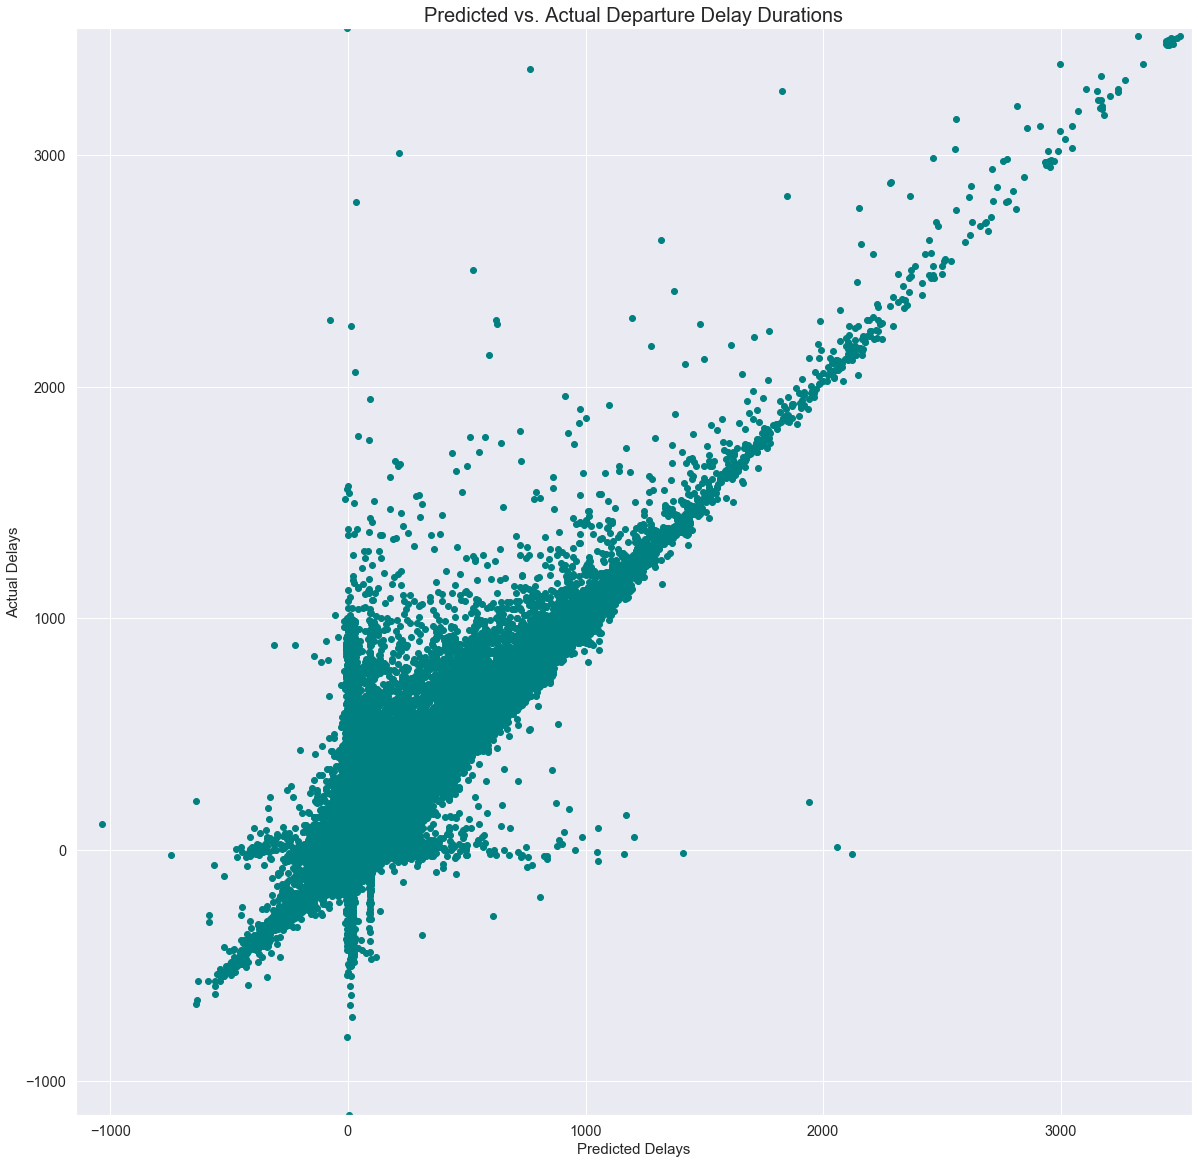

In [34]:
# Plot predicted vs. actuals
plt.figure(figsize=(20,20))
plt.scatter(lasso_pred,y_test, color='teal')
plt.xlim(min(y_test), max(y_test))
plt.ylim(min(y_test), max(y_test))
plt.xlabel('Predicted Delays')
plt.ylabel('Actual Delays')
plt.title('Predicted vs. Actual Departure Delay Durations')
plt.show()

Plotting the predicted and actual delays presents a relatively linear line at 45 degrees, indicating expected spread of residuals. 
There is more noticeable error between 0 and 2000 seconds delay wherein the actual delay was higher than predicted. This could be the case due to unforeseen sudden train delays not 
present in the data, such as mechanical issues.

# Full Model (w/ Lag Features) using Random Forest

In [36]:
random.seed(24)

# Split data into train, validate, and test
y = train_X.departure_delay
X = train_X.drop(['departure_delay'], axis=1)
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.7)
X_train, X_validate, y_train, y_validate = train_test_split(X_train_valid, y_train_valid, test_size=0.8)

#Create a parameter grid for max_depth and instantiate the regressor and grid search
max_depth_values = np.arange(9,30,3)
param_grid = {'max_depth':max_depth_values}
rf_reg_full = RandomForestRegressor(n_estimators=1000, verbose=1)

# Fit grid using training set
full_cv = GridSearchCV(rf_reg_full, param_grid, 'neg_mean_squared_error', cv=3)
full_cv.fit(X_train, y_train)

# Review results from grid search
print(full_cv.best_params_)
print(full_cv.best_score_)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed: 19.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed: 19.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed: 19.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[

KeyboardInterrupt: 

In [ ]:
# Plotting grid search results to compare performance across max_depth hyper parameters
plt.figure(figsize=(8,8))
_ = sns.barplot(x=max_depth_values,
                y=full_cv.cv_results_['mean_test_score'],
               color ='teal')
plt.title('Grid Search Output of Max Depth Parameter')
plt.xlabel('Max Depth Values')
plt.ylabel('Neg Mean Squared Error')

In [ ]:
# Select ideal max_depth value(s), re-fit on train and run on validation to measure over-fitting
max_depth_full = [9,27] # Enter selected max depth(s) here

rf_reg_full_vldtn_1 = RandomForestRegressor(n_estimators=1000, verbose=1, max_depth=max_depth_full[1])
rf_reg_full_vldtn_1.fit(X_train, y_train)
full_vldtn_1_pred = rf_reg_full_vldtn_1.predict(X_train)
full_vldtn_1_pred_mse = mean_squared_error(y_train,full_vldtn_1_pred)

rf_reg_full_vldtn_2 = RandomForestRegressor(n_estimators=1000, verbose=1, max_depth=max_depth_full[1])
rf_reg_full_vldtn_2.fit(X_train, y_train)
full_vldtn_2_pred = rf_reg_full_vldtn_2.predict(X_validate)
full_vldtn_2_pred_mse = mean_squared_error(y_validate,full_vldtn_2_pred)


In [ ]:
print(full_vldtn_1_pred_mse)
print(full_vldtn_2_pred_mse)


Comparing the performance of a max_depth==27 model using both validation and training sets indicates that the model is over-fitting with that max_depth.
Viewing the barchart printout from the gridsearch indicates minimal improvement from 21 onward. Thus, we may want to select 21.
However, performing a fit and predict on the training and validation sets, respectively, with max_depth of 21 performs worse than a max_depth of 27. 
Thus, below we are using 27.

In [37]:
# Run final fit on train + validation and prediction on test
rf_reg_full_test = RandomForestRegressor(n_estimators=1000, verbose=1, max_depth=27) # update max depth here
rf_reg_full_test.fit(X_train_valid, y_train_valid)
y_pred_full = rf_reg_full_test.predict(X_test)
y_pred_full_mse = mean_squared_error(y_test,y_pred_full)
print(y_pred_full_mse)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed: 450.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


2024.8475152916928


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  9.6min finished


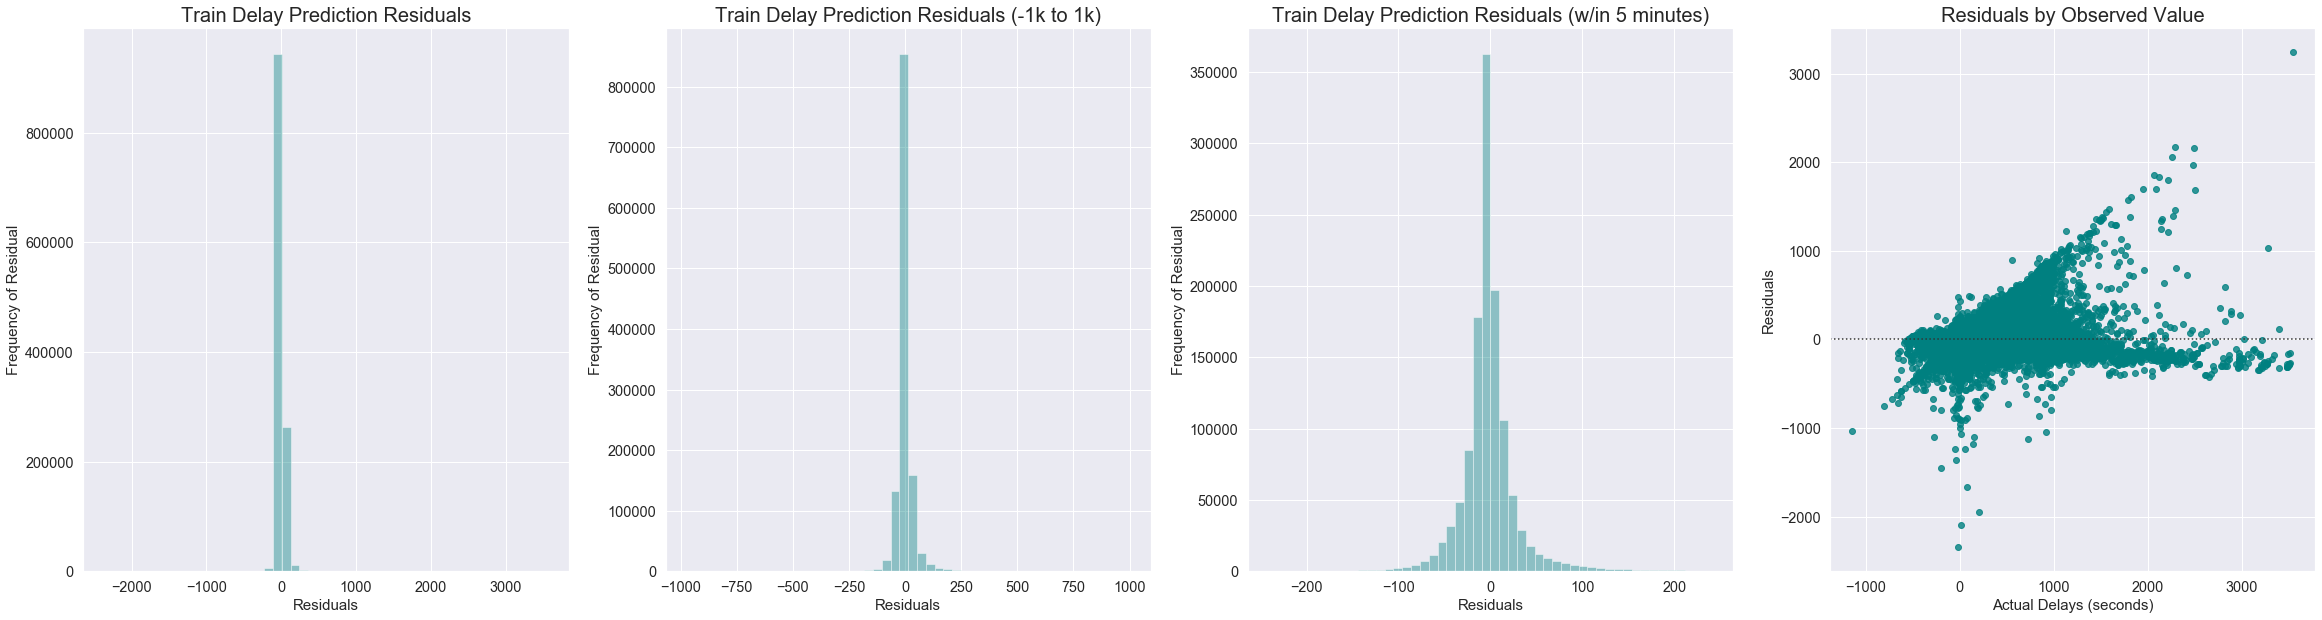

In [38]:
# Measure different time buckets of performance by comparing predicted and actual observations in departure delays
pred_full_df = pd.DataFrame({'y_pred_full':y_pred_full,
                               'y_test':y_test})

pred_full_df['resid'] = pred_full_df['y_test'] - pred_full_df['y_pred_full']

plt.figure(figsize=(40,10))
plt.subplot(1,4,1)
_ = sns.distplot(pred_full_df['resid'],
                kde=False,
                 color='teal')
plt.xlabel('Residuals')
plt.ylabel('Frequency of Residual')
plt.title('Train Delay Prediction Residuals')

plt.subplot(1,4,2)
_ = sns.distplot(pred_full_df['resid'].loc[(pred_full_df['resid']<=1000) & (pred_full_df['resid']>=-1000)],
                kde=False,
                 color='teal')
plt.xlabel('Residuals')
plt.ylabel('Frequency of Residual')
plt.title('Train Delay Prediction Residuals (-1k to 1k)')

plt.subplot(1,4,3)
_ = sns.distplot(pred_full_df['resid'].loc[(pred_full_df['resid']<=240) & (pred_full_df['resid']>=-240)],
                kde=False,
                 color='teal')
plt.xlabel('Residuals')
plt.ylabel('Frequency of Residual')
plt.title('Train Delay Prediction Residuals (w/in 5 minutes)')

plt.subplot(1,4,4)
_ = sns.residplot(x='y_test',
                 y='resid',
                 data=pred_full_df,
                 color='teal')
plt.xlabel('Actual Delays (seconds)')
plt.ylabel('Residuals')
plt.title('Residuals by Observed Value')


plt.show()

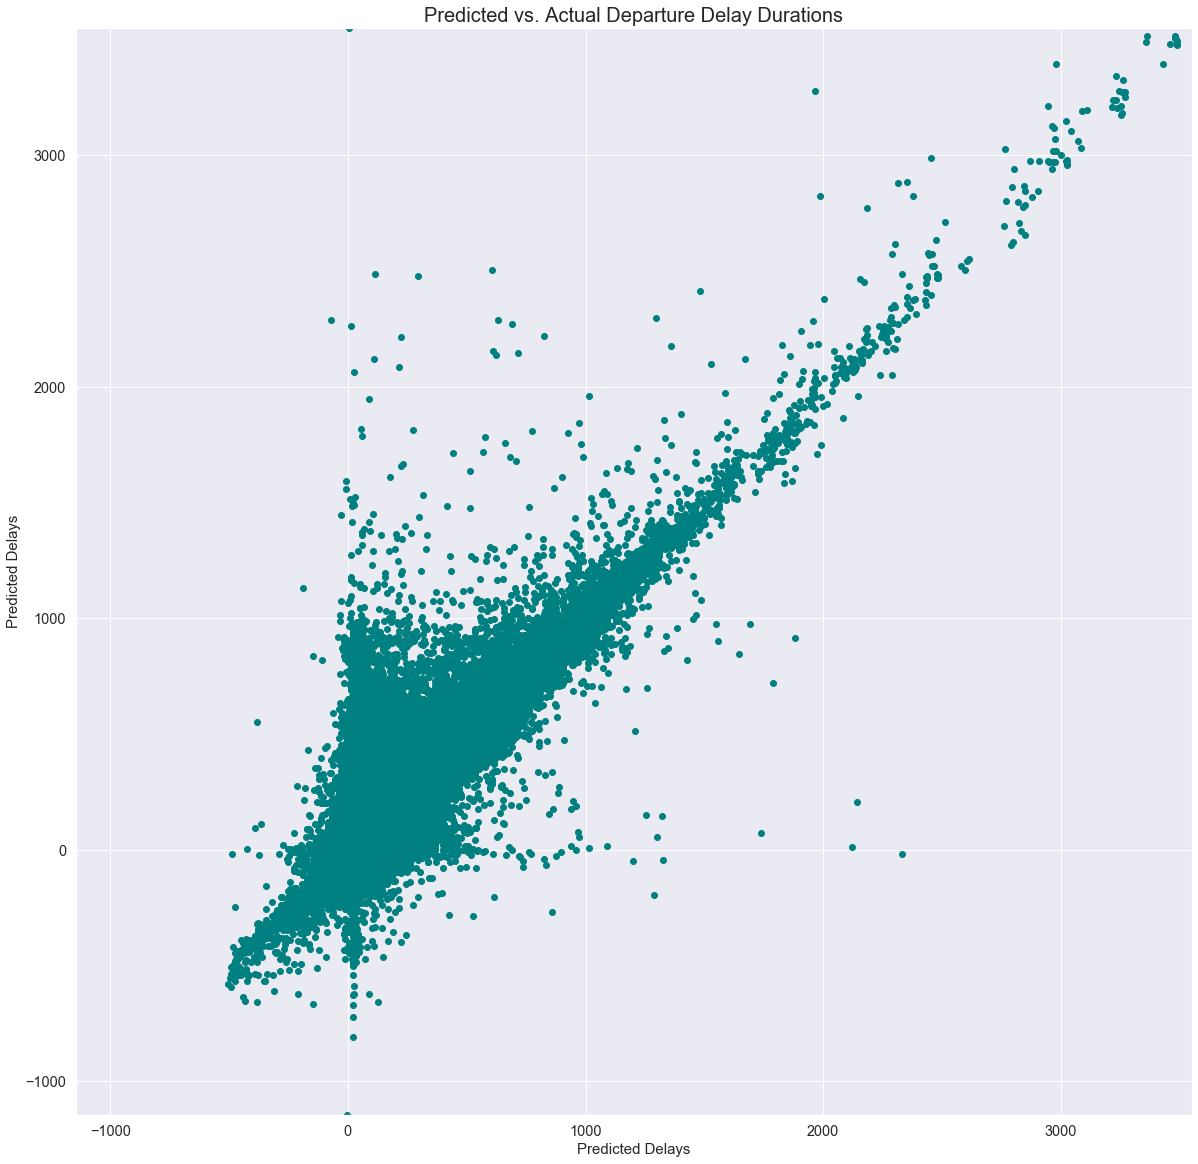

In [39]:
# Plot predicted vs. actuals
plt.figure(figsize=(20,20))
plt.scatter(y_pred_full,y_test, color='teal')
plt.xlim(min(y_test), max(y_test))
plt.ylim(min(y_test), max(y_test))
plt.xlabel('Predicted Delays')
plt.ylabel('Predicted Delays')
plt.title('Predicted vs. Actual Departure Delay Durations')
plt.show()

In [ ]:
delay_min, delay_max = pred_full_df['y_test'].min(), pred_full_df['y_test'].max() 
print(delay_min)
print(delay_max)

In [40]:
# Assuming delays are relatively normal, explore reasonable bin lengths separately in early and late departures
print('Early Departures')
print(pred_full_df.resid.loc[pred_full_df.y_test<0].describe().apply(lambda x: format(x, 'f')))
print(" ")
print('Late Departures')
print(pred_full_df.resid.loc[pred_full_df.y_test>=0].describe().apply(lambda x: format(x, 'f')))

# Set up bin ranges and labels
bins = [-15*60,
        -5*60,
        -2*60,
        0,
        2*60,
        5*60,
        10*60,
        15*60,
        20*60,
        30*60,
        60*60]
labels = ['15-5 min early',
          '5-2 min early',
          '<2 min early',
          '<2 min late',
          '2-5 min late',
          '5-10 min late',
          '10-15 min late',
          '15-20 min late',
          '20-30 min late',
          '30-60 min late']

print(' ')
print('Delayed Departure Bins')
for i,label in enumerate(labels):
    print(label+':' )
    print(bins[i], ' - ',bins[i+1])
    print(' ')

# Created delay bins for both the observed and predicted second delay durations with minute labels
pred_full_df['delay_bins'] = pd.cut(x=pred_full_df['y_test'], bins=bins, labels=labels)
pred_full_df['prediction_bins'] = pd.cut(x=pred_full_df['y_pred_full'], bins=bins, labels=labels)

# Flag records corresponding to a match bin value between the observed and predicted
pred_full_df.loc[pred_full_df['delay_bins'] == pred_full_df['prediction_bins'], 'match'] = 1
pred_full_df.loc[pred_full_df['delay_bins'] != pred_full_df['prediction_bins'], 'match'] = 0

display((pred_full_df).head(3))

Early Departures
count    203336.000000
mean        -17.659205
std          33.272766
min       -2349.121000
25%         -26.913089
50%          -8.664038
75%          -0.683996
max         469.292000
Name: resid, dtype: object
 
Late Departures
count    1026088.000000
mean           2.879868
std           46.223701
min        -2105.954000
25%          -12.065102
50%           -2.486902
75%            9.878653
max         3546.349619
Name: resid, dtype: object
 
Delayed Departure Bins
15-5 min early:
-900  -  -300
 
5-2 min early:
-300  -  -120
 
<2 min early:
-120  -  0
 
<2 min late:
0  -  120
 
2-5 min late:
120  -  300
 
5-10 min late:
300  -  600
 
10-15 min late:
600  -  900
 
15-20 min late:
900  -  1200
 
20-30 min late:
1200  -  1800
 
30-60 min late:
1800  -  3600
 


,y_pred_full,y_test,resid,delay_bins,prediction_bins,match
1690751,579.388882,553.0,-26.388882,5-10 min late,5-10 min late,1.0
1554331,155.608230,148.0,-7.608230,2-5 min late,2-5 min late,1.0
1421142,103.229056,124.0,20.770944,2-5 min late,<2 min late,0.0


<function matplotlib.pyplot.show(*args, **kw)>

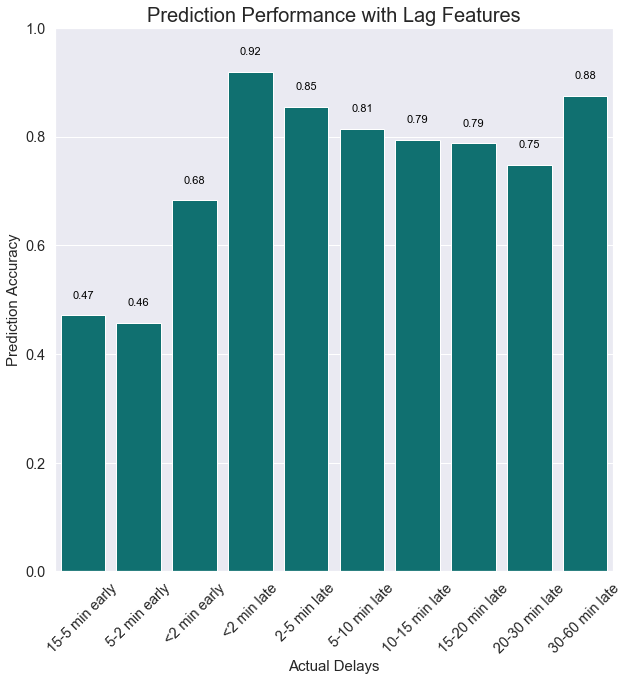

In [41]:
# Plot performance by time bucket and annotate bar with prediction accuracy
full_performance_buckets = pred_full_df.groupby(by='delay_bins', as_index=False).agg({'match':['count','sum']})
full_performance_buckets.columns = full_performance_buckets.columns.droplevel()
full_performance_buckets['accuracy'] = full_performance_buckets['sum'] / full_performance_buckets['count']
full_performance_buckets.head(3)

_ = plt.figure(figsize=(10,10))
g = sns.barplot(x='',
                y='accuracy',
                data=full_performance_buckets,
                color='teal')
ax=g
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='black', xytext=(0, 20),
                 textcoords='offset points')
plt.title('Prediction Performance with Lag Features')
plt.xlabel('Actual Delays')
plt.ylim(0,1)
plt.ylabel('Prediction Accuracy')
plt.xticks(rotation=45)
plt.show

# Reduced Model (w/o Lag Features) using Random Forest

In [ ]:
random.seed(24)

# Split data into train, validate, and test
y = train_X.departure_delay
X = train_X[train_X.columns.drop(list(train_X.filter(regex='prior_departure_delay')))]
X = X.drop(['departure_delay'], axis=1)
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.7)
X_train, X_validate, y_train, y_validate = train_test_split(X_train_valid, y_train_valid, test_size=0.8)

# Create a parameter grid for max_depth and instantiate the regressor and grid search
max_depth_values = np.arange(9,31,3)
param_grid = {'max_depth':max_depth_values}
rf_reg_reduced = RandomForestRegressor(n_estimators=1000, verbose=1)

# Fit grid using training set
reduced_cv = GridSearchCV(rf_reg_reduced, param_grid, 'neg_mean_squared_error', cv=3)

# Sample the training set for improved gridsearch runtime
idx = np.random.choice(np.arange(len(X_train)),5000, replace=True)
reduced_cv.fit(X_train.iloc[idx], y_train.iloc[idx])

# Review results from grid search
print(reduced_cv.best_params_)
print(reduced_cv.best_score_)


In [ ]:
# Plotting grid search results to compare performance across max_depth hyper parameters
max_depth_values = np.arange(9,31,3)
plt.figure(figsize=(8,8))
_ = sns.barplot(x=max_depth_values,
                y=reduced_cv.cv_results_['mean_test_score'],
               color ='teal')
plt.title('Grid Search Output of Max Depth Parameter')
plt.xlabel('Max Depth Values')
plt.ylabel('Neg Mean Squared Error')
# The below comparison does not show significant incremental changes in performance from 18 forward. A max_depth of 18 will be selected and verified for over-fitting below.

In [ ]:
# Select ideal max_depth value(s), re-fit on train and run on validation to measure over-fitting
max_depth_reduced = [18, 9] # Enter selected max depth(s) here

rf_reg_reduced_vldtn_1 = RandomForestRegressor(n_estimators=1000, verbose=1, max_depth=max_depth_reduced[0])
rf_reg_reduced_vldtn_1.fit(X_train, y_train)
reduced_vldtn_1_pred = rf_reg_reduced_vldtn_1.predict(X_train)
reduced_vldtn_1_pred_mse = mean_squared_error(y_train,reduced_vldtn_1_pred)

rf_reg_reduced_vldtn_2 = RandomForestRegressor(n_estimators=1000, verbose=1, max_depth=max_depth_reduced[0])
rf_reg_reduced_vldtn_2.fit(X_train, y_train)
reduced_vldtn_2_pred = rf_reg_reduced_vldtn_2.predict(X_validate)
reduced_vldtn_2_pred_mse = mean_squared_error(y_validate,reduced_vldtn_2_pred)

In [ ]:
print(reduced_vldtn_1_pred_mse)
print(reduced_vldtn_2_pred_mse)


In [ ]:
rf_reg_reduced_vldtn_1 = RandomForestRegressor(n_estimators=1000, verbose=1, max_depth=max_depth_reduced[1])
rf_reg_reduced_vldtn_1.fit(X_train, y_train)
reduced_vldtn_1_pred = rf_reg_reduced_vldtn_1.predict(X_train)
reduced_vldtn_1_pred_mse = mean_squared_error(y_train,reduced_vldtn_1_pred)

rf_reg_reduced_vldtn_2 = RandomForestRegressor(n_estimators=1000, verbose=1, max_depth=max_depth_reduced[1])
rf_reg_reduced_vldtn_2.fit(X_train, y_train)
reduced_vldtn_2_pred = rf_reg_reduced_vldtn_2.predict(X_validate)
reduced_vldtn_2_pred_mse = mean_squared_error(y_validate,reduced_vldtn_2_pred)

print(reduced_vldtn_1_pred_mse)
print(reduced_vldtn_2_pred_mse)


Using the validation set for an additional measure of over-fitting, the gridsearch recommendation of 21 shows generalization than  
a max_depth of 9 despite over-fitting. Thus, 21 will be selected here.

In [ ]:
# Run final fit on train + validation and prediction on test
rf_reg_reduced_test = RandomForestRegressor(n_estimators=1000, verbose=1, max_depth=max_depth_reduced[0]) # update max depth here
rf_reg_reduced_test.fit(X_train_valid, y_train_valid)
y_pred_reduced = rf_reg_reduced_test.predict(X_test)
y_pred_reduced_mse = mean_squared_error(y_test,y_pred_reduced)

In [ ]:
# Measure different time buckets of performance by comparing predicted and actual observations in departure delays
pred_reduced_df = pd.DataFrame({'y_pred_reduced':y_pred_reduced,
                               'y_test':y_test})

pred_reduced_df['resid'] = pred_reduced_df['y_test'] - pred_reduced_df['y_pred_reduced']

plt.figure(figsize=(40,10))
plt.subplot(1,4,1)
_ = sns.distplot(pred_reduced_df['resid'],
                kde=False,
                color='teal')
plt.xlabel('Residuals')
plt.ylabel('Frequency of Residual')
plt.title('Train Delay Prediction Residuals')

plt.subplot(1,4,2)
_ = sns.distplot(pred_reduced_df['resid'].loc[(pred_reduced_df['resid']<=1000) & (pred_reduced_df['resid']>=-1000)],
                kde=False,
                color='teal)
plt.xlabel('Residuals')
plt.ylabel('Frequency of Residual')
plt.title('Train Delay Prediction Residuals (-1k to 1k)')

plt.subplot(1,4,3)
_ = sns.distplot(pred_reduced_df['resid'].loc[(pred_reduced_df['resid']<=240) & (pred_reduced_df['resid']>=-240)],
                kde=False,
                color='teal)
plt.xlabel('Residuals')
plt.ylabel('Frequency of Residual')
plt.title('Train Delay Prediction Residuals (w/in 5 minutes)')

plt.subplot(1,4,4)
_ = sns.residplot(x='y_test',
                 y='resid',
                 data=pred_reduced_df,
                color='teal)
plt.xlabel('Actual Delays (seconds)')
plt.ylabel('Residuals')
plt.title('Residuals by Observed Value')


plt.show()

In [ ]:
delay_min, delay_max = pred_reduced_df['y_test'].min(), pred_reduced_df['y_test'].max() 
print(delay_min)
print(delay_max)

In [ ]:
# Assuming delays are relatively normal, explore reasonable bins separately in early and late departures
print('Early Departures')
print(pred_reduced_df.resid.loc[pred_reduced_df.y_test<0].describe().apply(lambda x: format(x, 'f')))
print(" ")
print('Late Departures')
print(pred_reduced_df.resid.loc[pred_reduced_df.y_test>=0].describe().apply(lambda x: format(x, 'f')))

# Set up bin ranges and labels
bins = [-15*60,
        -5*60,
        -2*60,
        0,
        2*60,
        5*60,
        10*60,
        15*60,
        20*60,
        30*60,
        60*60]
labels = ['15-5 min early',
          '5-2 min early',
          '<2 min early',
          '<2 min late',
          '2-5 min late',
          '5-10 min late',
          '10-15 min late',
          '15-20 min late',
          '20-30 min late',
          '30-60 min late']

print(' ')
print('Delayed Departure Bins')
for i,label in enumerate(labels):
    print(label+':' )
    print(bins[i], ' - ',bins[i+1])
    print(' ')

# Created delay bins for both the observed and predicted second delay durations with minute labels
pred_reduced_df['delay_bins'] = pd.cut(x=pred_reduced_df['y_test'], bins=bins, labels=labels)
pred_reduced_df['prediction_bins'] = pd.cut(x=pred_reduced_df['y_pred_reduced'], bins=bins, labels=labels)

# Flag records corresponding to a match bin value between the observed and predicted
pred_reduced_df.loc[pred_reduced_df['delay_bins'] == pred_reduced_df['prediction_bins'], 'match'] = 1
pred_reduced_df.loc[pred_reduced_df['delay_bins'] != pred_reduced_df['prediction_bins'], 'match'] = 0

display((pred_reduced_df).head(3))

In [ ]:
# Plot performance by time bucket and annotate bar with prediction accuracy
reduced_performance_buckets = pred_reduced_df.groupby(by='delay_bins', as_index=False).agg({'match':['count','sum']})
reduced_performance_buckets.columns = reduced_performance_buckets.columns.droplevel()
reduced_performance_buckets['accuracy'] = reduced_performance_buckets['sum'] / reduced_performance_buckets['count']
reduced_performance_buckets.head(3)

_ = plt.figure(figsize=(10,10))
g = sns.barplot(x='',
                y='accuracy',
                data=reduced_performance_buckets,
                color='dodgerblue')
ax=g
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='black', xytext=(0, 20), textcoords='offset points')
plt.title('Prediction Performance without Lag Features')
plt.xlabel('Actual Delays')
plt.ylim(0,1)
plt.ylabel('Prediction Accuracy')
plt.xticks(rotation=45)
plt.show()



The above shows rather poor performance for predicting train delays without lag features. Since drastic delays are generally caused by immediate complications,
such as employee issues, sudden mechanical issues, etc. these root causes nor the symptoms of them would be availabe in this dataset.

# Compare Runtime for a Minute's Worth of New Records Across Hyperparameter Possibilities

Since train progress happens on a minute basis, a quick comparison of different random forest max depth values were compared to see if there is a payoff between compute time and model performance. As noted below in the comparison, max depth values of 18 and 27 both predict quite fast and do not present a concern from a prediction time perspective.

In [42]:
# Identify busiest minute of data
minute_df = train_X_duplicate[['time_scheduled','departure_delay']].set_index('time_scheduled')

minute_df.resample('min').count().sort_values(by='departure_delay',ascending=False).head(1)

# The busiest minute in the dataset is between '2019-08-30 16:13:00' and '2019-08-30 16:13:59'

,departure_delay
time_scheduled,
2019-08-30 16:13:00,18


In [43]:
# New training and testing sets will be created with the testing set corresponding to the 18 rows in the above minute
random.seed(24)

test_idx = train_X_duplicate.loc[(train_X_duplicate.time_scheduled>='2019-08-30 16:13:00') & (train_X_duplicate.time_scheduled<='2019-08-30 16:14:59')].index
training_set_df = train_X.loc[~train_X.index.isin(test_idx)].sample(n=5000)

# Create training and testing sets
X_train = training_set_df.drop(['departure_delay'],axis=1)
y_train = training_set_df['departure_delay']
X_test = train_X.iloc[test_idx].drop(['departure_delay'],axis=1)

# Instantiate regressor(s) and train each
time_comp_18 = RandomForestRegressor(n_estimators=1000, verbose=1, max_depth=18) 
time_comp_18.fit(X_train, y_train)
time_comp_27 = RandomForestRegressor(n_estimators=1000, verbose=1, max_depth=27) 
time_comp_27.fit(X_train, y_train)

%timeit -t time_comp_18.predict(X_test)
%timeit -t time_comp_27.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[

105 ms ± 2.65 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[

109 ms ± 3.31 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


# Full Model (w/ Lag Features) using xgboost

Below will feature more modeling to determine if extreme gradient boosting (xgboost) with more thorough hyperparameter tuning will render improved perforamnce for the full model with lag features.

In [ ]:
# Create a training set just for xgboost hyper-parameter tuning
train = train_X.sample(n=10000, random_state=24)
target = 'departure_delay'
predictors = [x for x in train.columns if x not in [target]]

In [ ]:
# Create a reusable function to iterative hyper-parameter tuning that uses both cross-validation of xgb and sklearn's XGBRegressor algo
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=3, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='rmse', early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['departure_delay'],eval_metric='rmse')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
        
    #Print model report:
    print ("\nModel Report")
    print ("Mean Squared Error : %.4g" % mean_squared_error(dtrain['departure_delay'].values, dtrain_predictions))
                    
    # Plot predicted vs. actuals
    plt.figure(figsize=(10,10))
    plt.scatter(dtrain_predictions,dtrain['departure_delay'].values, color='teal')
    plt.xlim(min(dtrain['departure_delay'].values), max(dtrain['departure_delay'].values))
    plt.ylim(min(dtrain['departure_delay'].values), max(dtrain['departure_delay'].values))
    plt.xlabel('Predicted Delays')
    plt.ylabel('Actual Delays')
    plt.title('Predicted vs. Actual Departure Delay Durations')
    plt.show()

In [ ]:
# Create a baseline prediction on training set with n_estimators = 1000
xgb1 = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:squarederror',
 scale_pos_weight=1,
 seed=24)
modelfit(xgb1, train, predictors)

In [ ]:
# Another itation of tuning focusing on max_depth and min_child_weight while keeping other parameters constant

# Create parameters for gridsearch
param_test1 = {
 'max_depth':range(3,25,3),
 'min_child_weight':range(1,6,2)
}

# Instantiate gridsearch and estimator with most recently updated parameters
gsearch1 = GridSearchCV(estimator = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:squarederror',
 scale_pos_weight=1,
 seed=24),
          param_grid = param_test1, scoring='neg_mean_squared_error',n_jobs=4, cv=3)

# Fit gridsearch
gsearch1.fit(train[predictors],train[target])

# Create dataframe from grid search results, display, and plot results
cv_results = pd.DataFrame(gsearch1.cv_results_)
display(cv_results[['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score', ascending=True))

# Plot results
plt.figure(figsize=(8,8))
_ = sns.barplot(x='rank_test_score',
                y=cv_results.mean_test_score.abs(),
                color ='teal',
                data=cv_results)
plt.title('Grid Search Parameter Results')
plt.xlabel('Rank')
plt.ylabel('Mean Squared Error')
plt.show()
print(gsearch1.best_params_, gsearch1.best_score_)

In [ ]:
# The Max Depth of 3 is quite low but below we will try 1 above and below for more precise tuning. We will do the same for the min child weight as well.

# Create parameters for gridsearch
param_test2 = {
 'max_depth':[2,3,4],
 'min_child_weight':[4,5,6]
}

# Instantiate gridsearch and estimator with most recently updated parameters
gsearch2 = GridSearchCV(estimator = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:squarederror',
 scale_pos_weight=1,
 seed=24),
          param_grid = param_test2, scoring='neg_mean_squared_error', n_jobs=4, cv=3)

# Fit gridsearch
gsearch2.fit(train[predictors],train[target])

# Create dataframe from grid search results, display, and plot results
cv_results = pd.DataFrame(gsearch2.cv_results_)
display(cv_results[['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score', ascending=True))

# Plot results
plt.figure(figsize=(8,8))
_ = sns.barplot(x='rank_test_score',
                y=cv_results.mean_test_score.abs(),
                color ='teal',
                data=cv_results)
plt.title('Grid Search Parameter Results')
plt.xlabel('Rank')
plt.ylabel('Mean Squared Error')
plt.show()
print(gsearch2.best_params_, gsearch2.best_score_)

In [ ]:
# Above the gridsearch indicates optimal values of max depth remains 3 and 4 is the optimal value for min child weight
# Another itation of tuning focusing on gamma while updating max depth and min child weight

# Create parameters for gridsearch
param_test3 = {
  'gamma':[i/10.0 for i in range(0,10)]
}

# Instantiate gridsearch and estimator with most recently updated parameters
gsearch3 = GridSearchCV(estimator = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=4,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:squarederror',
 scale_pos_weight=1,
 seed=24),
          param_grid = param_test3, scoring='neg_mean_squared_error', n_jobs=4, cv=3)

# Fit gridsearch
gsearch3.fit(train[predictors],train[target])

# Create dataframe from grid search results, display, and plot results
cv_results = pd.DataFrame(gsearch3.cv_results_)
display(cv_results[['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score', ascending=True))

# Plot results
plt.figure(figsize=(8,8))
_ = sns.barplot(x='rank_test_score',
                y=cv_results.mean_test_score.abs(),
                color ='teal',
                data=cv_results)
plt.title('Grid Search Parameter Results')
plt.xlabel('Rank')
plt.ylabel('Mean Squared Error')
plt.show()
print(gsearch3.best_params_, gsearch3.best_score_)

Incremental performance improvements continue to get smaller as tuning continues. 
Optimal parameters thus far are below:

| Parameter                           | Value       |   
| -----------                         | ----------- |
| max_depth                           | 3           |
| min_child_weight                    | 4           |
| gamma                               | 0           |

Next we will tune subsample, colsample_bytree, regularization (although expectation that this is minimal), and finally more tuning for learning rate in combination with n_estimators.

In [ ]:
# Another itation of tuning focusing on subsample and colsample_bytree. Tuning will be done in 2 stages.

# Create parameters for gridsearch
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

# Instantiate gridsearch and estimator with most recently updated parameters
gsearch4 = GridSearchCV(estimator = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=4,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:squarederror',
 scale_pos_weight=1,
 seed=24),
          param_grid = param_test4, scoring='neg_mean_squared_error', n_jobs=4, cv=3)

# Fit gridsearch
gsearch4.fit(train[predictors],train[target])

# Create dataframe from grid search results, display, and plot results
cv_results = pd.DataFrame(gsearch4.cv_results_)
display(cv_results[['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score', ascending=True))

# Plot results
plt.figure(figsize=(8,8))
_ = sns.barplot(x='rank_test_score',
                y=cv_results.mean_test_score.abs(),
                color ='teal',
                data=cv_results)
plt.title('Grid Search Parameter Results')
plt.xlabel('Rank')
plt.ylabel('Mean Squared Error')
plt.show()
print(gsearch4.best_params_, gsearch4.best_score_)

In [ ]:
# Another itation of tuning focusing on subsample and colsample_bytree. We will further tune the same parameters using smaller intervals of 0.05 closer to the optimal values shown above.

# Create parameters for gridsearch
param_test5 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}

# Instantiate gridsearch and estimator with most recently updated parameters
gsearch5 = GridSearchCV(estimator = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=4,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:squarederror',
 scale_pos_weight=1,
 seed=24),
          param_grid = param_test5, scoring='neg_mean_squared_error', n_jobs=4, cv=3)

# Fit gridsearch
gsearch5.fit(train[predictors],train[target])

# Create dataframe from grid search results, display, and plot results
cv_results = pd.DataFrame(gsearch5.cv_results_)
display(cv_results[['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score', ascending=True))

# Plot results
plt.figure(figsize=(8,8))
_ = sns.barplot(x='rank_test_score',
                y=cv_results.mean_test_score.abs(),
                color ='teal',
                data=cv_results)
plt.title('Grid Search Parameter Results')
plt.xlabel('Rank')
plt.ylabel('Mean Squared Error')
plt.show()
print(gsearch5.best_params_, gsearch5.best_score_)

We see slight improvements using more granular values for colsample_bytree and subsample. Optimal parameters thus far are below:

| Parameter                           | Value       |   
| -----------                         | ----------- |
| max_depth                           | 3           |
| min_child_weight                    | 4           |
| gamma                               | 0           |
| colsample_bytree                    | 8.5         |
| subsample                           | 8.5         |

In [ ]:
# Another itation of tuning focusing on regularization to reduce overfitting. The prior lasso algorithm indicated a very low regularization constant was necessary so the same may be true here.

# Create parameters for gridsearch
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

# Instantiate gridsearch and estimator with most recently updated parameters
gsearch6 = GridSearchCV(estimator = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=4,
 gamma=0,
 subsample=0.85,
 colsample_bytree=0.85,
 objective= 'reg:squarederror',
 scale_pos_weight=1,
 seed=24),
          param_grid = param_test6, scoring='neg_mean_squared_error', n_jobs=4, cv=3)

# Fit gridsearch
gsearch6.fit(train[predictors],train[target])

# Create dataframe from grid search results, display, and plot results
cv_results = pd.DataFrame(gsearch6.cv_results_)
display(cv_results[['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score', ascending=True))

# Plot results
plt.figure(figsize=(8,8))
_ = sns.barplot(x='rank_test_score',
                y=cv_results.mean_test_score.abs(),
                color ='teal',
                data=cv_results)
plt.title('Grid Search Parameter Results')
plt.xlabel('Rank')
plt.ylabel('Mean Squared Error')
plt.show()
print(gsearch6.best_params_, gsearch6.best_score_)

In [ ]:
# Since the lower end of the regularization parameter was the optimal value, we will try a slight increase above and below it for more precise tuning

# Create parameters for gridsearch
param_test7 = {
 'reg_alpha':[1e-6, 1e-5, 1e-4]
}

# Instantiate gridsearch and estimator with most recently updated parameters
gsearch7 = GridSearchCV(estimator = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=4,
 gamma=0,
 subsample=0.85,
 colsample_bytree=0.85,
 objective= 'reg:squarederror',
 scale_pos_weight=1,
 seed=24),
          param_grid = param_test7, scoring='neg_mean_squared_error', n_jobs=4, cv=3)

# Fit gridsearch
gsearch7.fit(train[predictors],train[target])

# Create dataframe from grid search results, display, and plot results
cv_results = pd.DataFrame(gsearch7.cv_results_)
display(cv_results[['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score', ascending=True))

# Plot results
plt.figure(figsize=(8,8))
_ = sns.barplot(x='rank_test_score',
                y=cv_results.mean_test_score.abs(),
                color ='teal',
                data=cv_results)
plt.title('Grid Search Parameter Results')
plt.xlabel('Rank')
plt.ylabel('Mean Squared Error')
plt.show()
print(gsearch7.best_params_, gsearch7.best_score_)

In [ ]:
Optimal parameters thus far are below:

| Parameter                           | Value       |   
| -----------                         | ----------- |
| max_depth                           | 3           |
| min_child_weight                    | 4           |
| gamma                               | 0           |
| colsample_bytree                    | 0.85        |
| subsample                           | 0.85        |
| reg_alpha                           | 1e-05       |

In [ ]:
# With the above parameters held constant, we will do some final tuning/validation of the learning rate and n_estimators. They should change inversely to each other.
# Create parameters for gridsearch
param_test8 = {
 'n_estimators':[i for i in range(500,3000,500)],
 'learning_rate':[n/100.0 for n in range(1,21,3)]  
}

# Instantiate gridsearch and estimator with most recently updated parameters
gsearch8 = GridSearchCV(estimator = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=4,
 gamma=0,
 reg_alpha=1e-05 ,
 subsample=0.85,
 colsample_bytree=0.85,
 objective= 'reg:squarederror',
 scale_pos_weight=1,
 seed=24),
          param_grid = param_test8, scoring='neg_mean_squared_error', n_jobs=4, cv=3)

# Fit gridsearch
gsearch8.fit(train[predictors],train[target])

# Create dataframe from grid search results, display, and plot results
cv_results = pd.DataFrame(gsearch8.cv_results_)
display(cv_results[['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score', ascending=True))

# Plot results
plt.figure(figsize=(8,8))
_ = sns.barplot(x='rank_test_score',
                y=cv_results.mean_test_score.abs(),
                color ='teal',
                data=cv_results)
plt.title('Grid Search Parameter Results')
plt.xlabel('Rank')
plt.ylabel('Mean Squared Error')
plt.show()
print(gsearch8.best_params_, gsearch8.best_score_)

In [ ]:
# A fairly large increase is seen with a learning rate of 0.1 and n_estimators of 500 so we will explore more tuning for a more precise number of trees around 500

# Create parameters for gridsearch
param_test9 = {
 'n_estimators':[i for i in range(400,950,50)],
}

# Instantiate gridsearch and estimator with most recently updated parameters
gsearch9 = GridSearchCV(estimator = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=4,
 gamma=0,
 reg_alpha=1e-05 ,
 subsample=0.85,
 colsample_bytree=0.85,
 objective= 'reg:squarederror',
 scale_pos_weight=1,
 seed=24),
          param_grid = param_test9, scoring='neg_mean_squared_error', n_jobs=4, cv=3)

# Fit gridsearch
gsearch9.fit(train[predictors],train[target])

# Create dataframe from grid search results, display, and plot results
cv_results = pd.DataFrame(gsearch9.cv_results_)
display(cv_results[['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score', ascending=True))

# Plot results
plt.figure(figsize=(8,8))
_ = sns.barplot(x='rank_test_score',
                y=cv_results.mean_test_score.abs(),
                color ='teal',
                data=cv_results)
plt.title('Grid Search Parameter Results')
plt.xlabel('Rank')
plt.ylabel('Mean Squared Error')
plt.show()
print(gsearch9.best_params_, gsearch9.best_score_)

In [ ]:
# Define new training and testing sets using the tuned hyperparameters from above, including n_estimators=550
random.seed(24)

# Split data into train, validate, and test
y = train_X.departure_delay
X = train_X.drop(['departure_delay'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

xgb = XGBRegressor(
 learning_rate =0.1,
 n_estimators=550,
 max_depth=3,
 min_child_weight=4,
 gamma=0,
 reg_alpha=1e-05 ,
 subsample=0.85,
 colsample_bytree=0.85,
 objective= 'reg:squarederror',
 scale_pos_weight=1)

xgb.fit(X_train,y_train)
training_predictions = xgb.predict(X_train)
print("Training mean squared error:",mean_squared_error(y_train,training_predictions))
testing_predictions = xgb.predict(X_test)
print("Testing mean squared error:",mean_squared_error(y_test,testing_predictions))

In [ ]:
# Measure different time buckets of performance by comparing predicted and actual observations in departure delays
pred_xgb_df = pd.DataFrame({'y_pred':testing_predictions,
                               'y_test':y_test})

pred_xgb_df['resid'] = pred_xgb_df['y_test'] - pred_xgb_df['y_pred']

# Set up bin ranges and labels
bins = [-15*60,
        -5*60,
        -2*60,
        0,
        2*60,
        5*60,
        10*60,
        15*60,
        20*60,
        30*60,
        60*60]
labels = ['15-5 min early',
          '5-2 min early',
          '<2 min early',
          '<2 min late',
          '2-5 min late',
          '5-10 min late',
          '10-15 min late',
          '15-20 min late',
          '20-30 min late',
          '30-60 min late']

print(' ')
print('Delayed Departure Bins')
for i,label in enumerate(labels):
    print(label+':' )
    print(bins[i], ' - ',bins[i+1])
    print(' ')

# Created delay bins for both the observed and predicted second delay durations with minute labels
pred_xgb_df['delay_bins'] = pd.cut(x=pred_xgb_df['y_test'], bins=bins, labels=labels)
pred_xgb_df['prediction_bins'] = pd.cut(x=pred_xgb_df['y_pred'], bins=bins, labels=labels)

# Flag records corresponding to a match bin value between the observed and predicted
pred_xgb_df.loc[pred_xgb_df['delay_bins'] == pred_xgb_df['prediction_bins'], 'match'] = 1
pred_xgb_df.loc[pred_xgb_df['delay_bins'] != pred_xgb_df['prediction_bins'], 'match'] = 0

# Plot performance by time bucket and annotate bar with prediction accuracy
full_performance_buckets = pred_xgb_df.groupby(by='delay_bins', as_index=False).agg({'match':['count','sum']})
full_performance_buckets.columns = full_performance_buckets.columns.droplevel()
full_performance_buckets['accuracy'] = full_performance_buckets['sum'] / full_performance_buckets['count']
full_performance_buckets.head(3)

_ = plt.figure(figsize=(10,10))
g = sns.barplot(x='',
                y='accuracy',
                data=full_performance_buckets,
                color='teal')
ax=g
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='black', xytext=(0, 20),
                 textcoords='offset points')
plt.title('Prediction Performance with Lag Features')
plt.xlabel('Actual Delays')
plt.ylim(0,1)
plt.ylabel('Prediction Accuracy')
plt.xticks(rotation=45)
plt.show

In [44]:
# The above mean squared error is higher than expected. Below we try with a higher number of n_estimators as the training size we rather small.
random.seed(24)

# Split data into train, validate, and test
y = train_X.departure_delay
X = train_X.drop(['departure_delay'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

xgb = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=4,
 gamma=0,
 reg_alpha=1e-05 ,
 subsample=0.85,
 colsample_bytree=0.85,
 objective= 'reg:squarederror',
 scale_pos_weight=1)

xgb.fit(X_train,y_train)
training_predictions = xgb.predict(X_train)
print("Training mean squared error:",mean_squared_error(y_train,training_predictions))
testing_predictions = xgb.predict(X_test)
print("Testing mean squared error:",mean_squared_error(y_test,testing_predictions))

Training mean squared error: 1896.7303143979698
Testing mean squared error: 1979.7135171958682


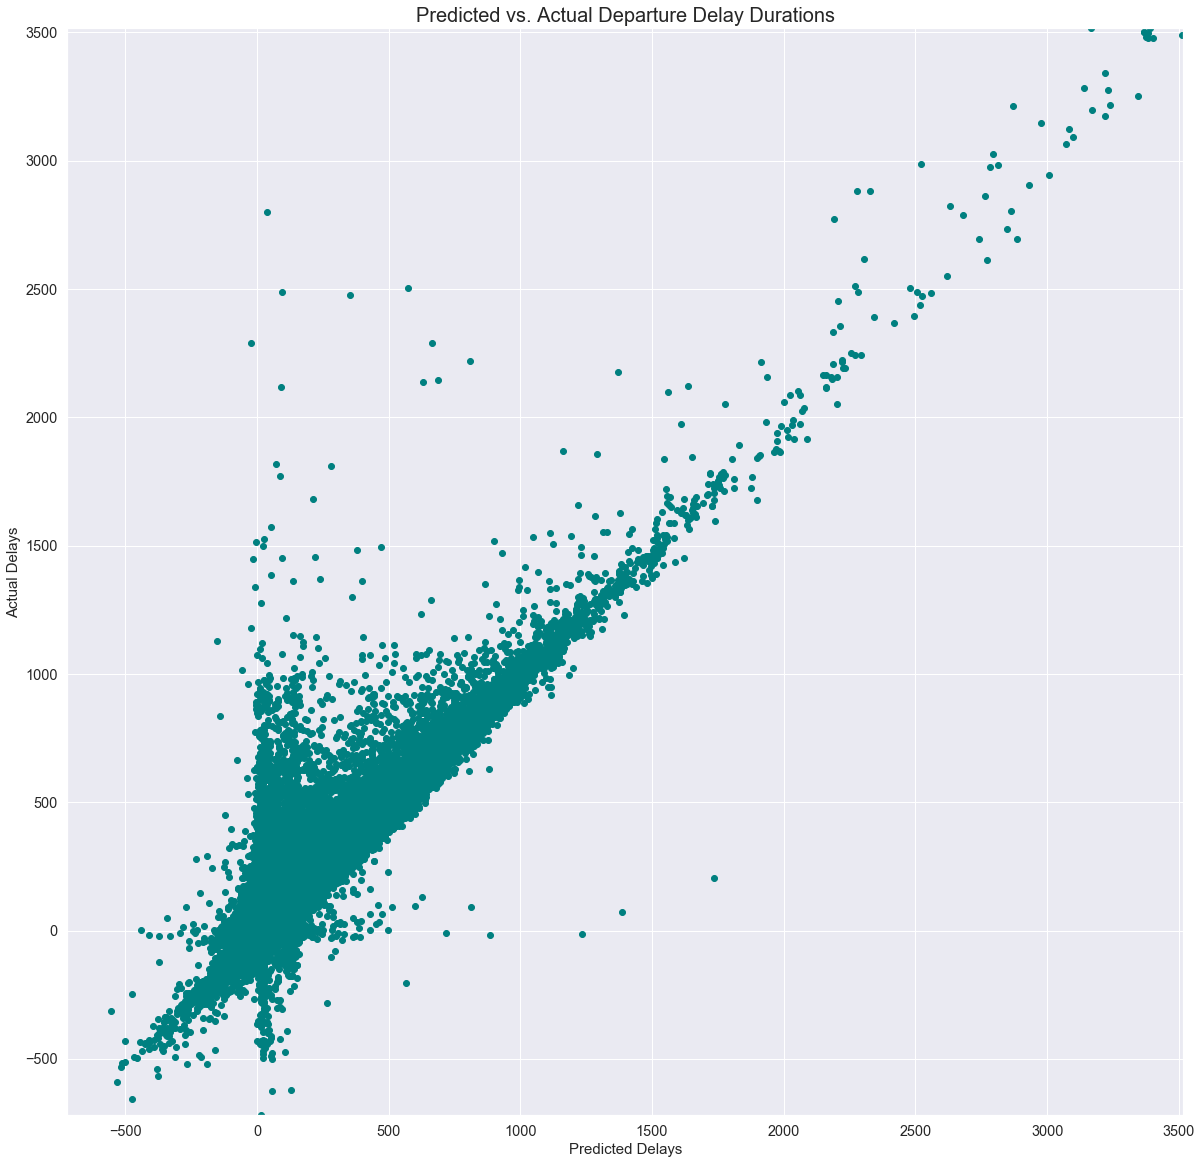

In [45]:
# Plot predicted vs. actuals
plt.figure(figsize=(20,20))
plt.scatter(testing_predictions,y_test, color='teal')
plt.xlim(min(y_test), max(y_test))
plt.ylim(min(y_test), max(y_test))
plt.xlabel('Predicted Delays')
plt.ylabel('Actual Delays')
plt.title('Predicted vs. Actual Departure Delay Durations')
plt.show()

 
Delayed Departure Bins
15-5 min early:
-900  -  -300
 
5-2 min early:
-300  -  -120
 
<2 min early:
-120  -  0
 
<2 min late:
0  -  120
 
2-5 min late:
120  -  300
 
5-10 min late:
300  -  600
 
10-15 min late:
600  -  900
 
15-20 min late:
900  -  1200
 
20-30 min late:
1200  -  1800
 
30-60 min late:
1800  -  3600
 


<function matplotlib.pyplot.show(*args, **kw)>

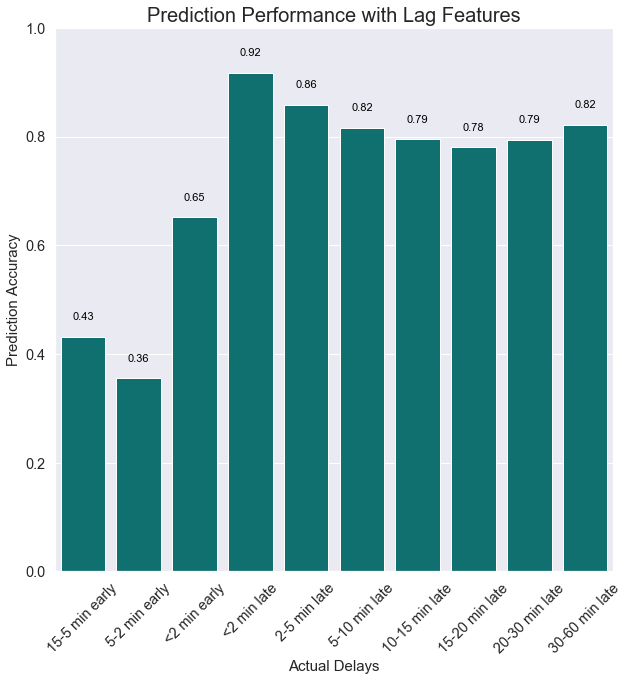

In [46]:
# Measure different time buckets of performance by comparing predicted and actual observations in departure delays
pred_xgb_df = pd.DataFrame({'y_pred':testing_predictions,
                               'y_test':y_test})

pred_xgb_df['resid'] = pred_xgb_df['y_test'] - pred_xgb_df['y_pred']

# Set up bin ranges and labels
bins = [-15*60,
        -5*60,
        -2*60,
        0,
        2*60,
        5*60,
        10*60,
        15*60,
        20*60,
        30*60,
        60*60]
labels = ['15-5 min early',
          '5-2 min early',
          '<2 min early',
          '<2 min late',
          '2-5 min late',
          '5-10 min late',
          '10-15 min late',
          '15-20 min late',
          '20-30 min late',
          '30-60 min late']

print(' ')
print('Delayed Departure Bins')
for i,label in enumerate(labels):
    print(label+':' )
    print(bins[i], ' - ',bins[i+1])
    print(' ')

# Created delay bins for both the observed and predicted second delay durations with minute labels
pred_xgb_df['delay_bins'] = pd.cut(x=pred_xgb_df['y_test'], bins=bins, labels=labels)
pred_xgb_df['prediction_bins'] = pd.cut(x=pred_xgb_df['y_pred'], bins=bins, labels=labels)

# Flag records corresponding to a match bin value between the observed and predicted
pred_xgb_df.loc[pred_xgb_df['delay_bins'] == pred_xgb_df['prediction_bins'], 'match'] = 1
pred_xgb_df.loc[pred_xgb_df['delay_bins'] != pred_xgb_df['prediction_bins'], 'match'] = 0

# Plot performance by time bucket and annotate bar with prediction accuracy
full_performance_buckets = pred_xgb_df.groupby(by='delay_bins', as_index=False).agg({'match':['count','sum']})
full_performance_buckets.columns = full_performance_buckets.columns.droplevel()
full_performance_buckets['accuracy'] = full_performance_buckets['sum'] / full_performance_buckets['count']
full_performance_buckets.head(3)

_ = plt.figure(figsize=(10,10))
g = sns.barplot(x='',
                y='accuracy',
                data=full_performance_buckets,
                color='teal')
ax=g
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='black', xytext=(0, 20),
                 textcoords='offset points')
plt.title('Prediction Performance with Lag Features')
plt.xlabel('Actual Delays')
plt.ylim(0,1)
plt.ylabel('Prediction Accuracy')
plt.xticks(rotation=45)
plt.show